In [13]:
import model_mobster_mv
import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy import stats

import torch
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics.cluster import normalized_mutual_info_score

from utils.plot_functions import *
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_paretos_1(mb):
    alpha_pareto = mb.params["alpha_pareto_param"].detach().numpy()
    fig, ax = plt.subplots(nrows=alpha_pareto.shape[0], ncols=alpha_pareto.shape[1])
    fig.tight_layout()
    x = np.arange(0,0.5,0.001)
    k = 0
    for d in range(alpha_pareto.shape[1]):
        pdf = stats.pareto.pdf(x, alpha_pareto[k,d], scale=0.01)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d} - alpha {round(float(alpha_pareto[k,d]), ndigits=2)}")

def plot_betas_1(mb):
    phi_beta = mb.params["phi_beta_param"].detach().numpy()
    kappa_beta = mb.params["k_beta_param"].detach().numpy()

    fig, ax = plt.subplots(nrows=phi_beta.shape[0], ncols=phi_beta.shape[1])
    fig.tight_layout()
    x = np.arange(0,1,0.001)
    k = 0
    for d in range(phi_beta.shape[1]):
        a = phi_beta[k,d]*kappa_beta[k,d]
        b = (1-phi_beta[k,d])*kappa_beta[k,d]
        pdf = stats.beta.pdf(x, a, b)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_xlim([0,1])
        ax[d].set_title(f"Dimension {d}")

In [3]:
def log_sum_exp(args):
    if len(args.shape) == 1:
        args = args.unsqueeze(0)
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

def beta_lk(data, DP, a_beta, b_beta):
    return dist.BetaBinomial(a_beta, b_beta, total_count=DP).log_prob(data) # simply does log(density)

def pareto_lk(data, DP, alpha):
    LINSPACE = 2000
    x = torch.linspace(0.01, 0.55, LINSPACE)
    y_1 = BoundedPareto(0.01, alpha, 0.55).log_prob(x).exp()
    y_2 = dist.Binomial(probs = x.repeat([data.shape[0],1]).reshape([LINSPACE,-1]), total_count=DP).log_prob(data).exp()
    pareto = torch.trapz(y_1.reshape([LINSPACE, 1]) * y_2, x =  x, dim = 0).log()
    return pareto

def compute_likelihood(mb, beta = True, dim = 0, k = 0):
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    if beta == True:
        phi_beta = mb.params["phi_beta_param"][k, dim]
        k_beta = mb.params["k_beta_param"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        return log_sum_exp(beta_lk(NV, DP, a_beta, b_beta)).sum()
    else:
        alpha = mb.params["alpha_pareto_param"][k, dim]
        return log_sum_exp(pareto_lk(NV, DP, alpha)).sum()

### One beta component

Trying to understand if the problem is the $\delta$ or the parameter convergence:
- if one dim of the cluster is assigned to the pareto but the likelihood of beta is higher, then the $\delta$ is wrong
- if one dim of the cluster is assigned to the pareto and the likelihood of pareto is higher, then the parameter convergence is wrong

In [18]:
N1 = 1000
seed = 123
# Component 1
phi_beta_x = 0.1
k_beta_x = 250
phi_beta_y = 0.1
k_beta_y= 250
n1=150
NV, DP = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n1, N=N1, seed=seed)
# 
print(DP.shape)

torch.Size([1000, 2])


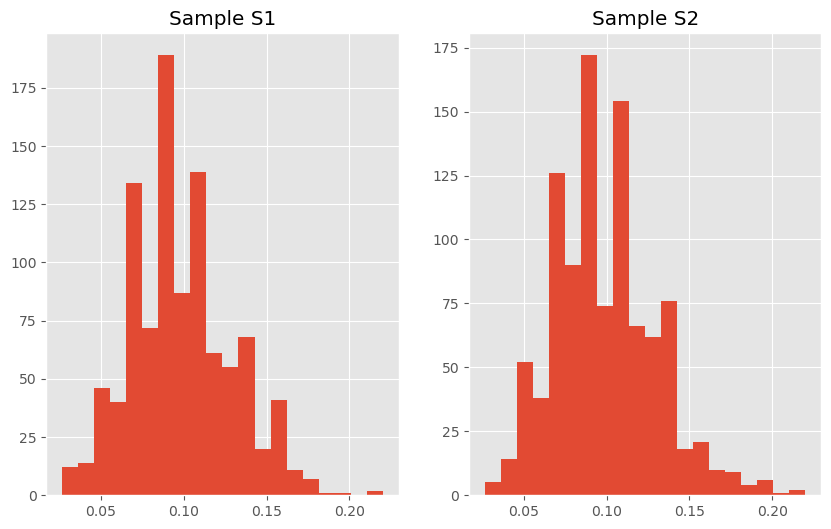

In [19]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [20]:
labels = np.zeros(N1)

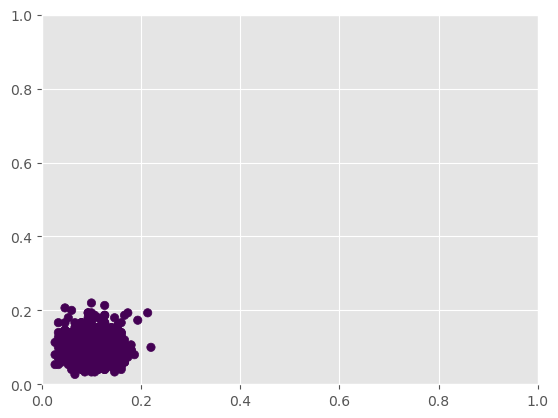

In [21]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K =  1
Beta:  tensor([[1.9799, 2.4966]])
Pareto:  tensor([[0.0275, 0.0112]])
Iteration 0: Loss = 7321542.5
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0168, 0.9826]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.1351, 0.0921]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 98.0547, 102.0206]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3909, 0.6091],
         [0.3904, 0.6096]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 5967789.0
Iteration 400: Loss = 5886818.5
Iteration 600: Loss = 5881887.5
Iteration 800: Loss = 5872258.0
Iteration 1000: Loss = 5869682.5
Iteration 1200: Loss = 5872503.5
Iteration 1400: Loss = 5869070.5
phi_beta [[0.09873191 0.09948613]]


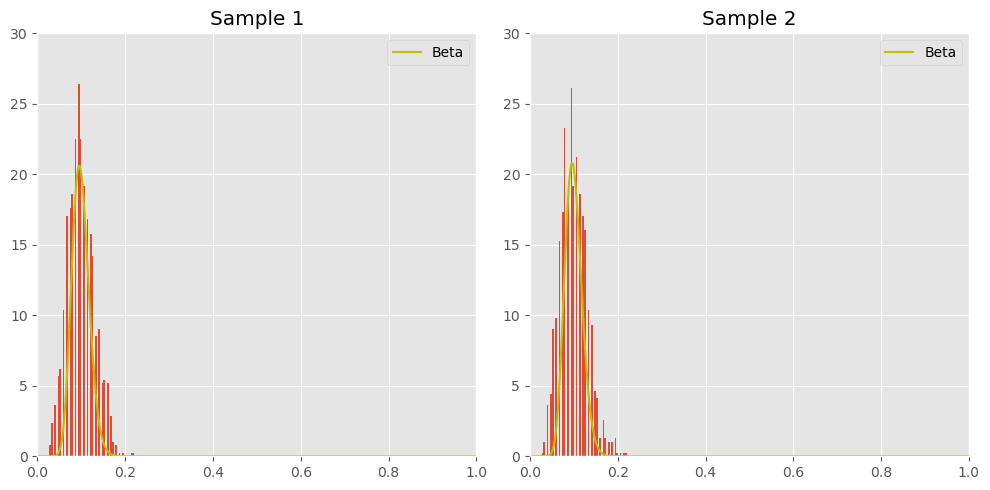

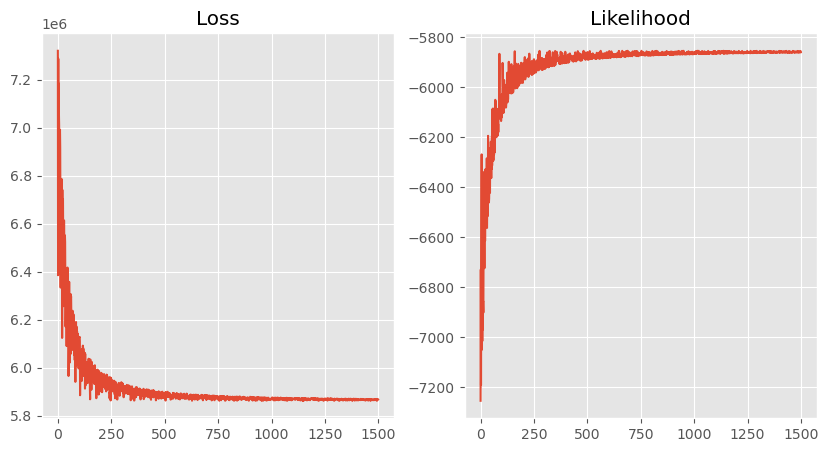

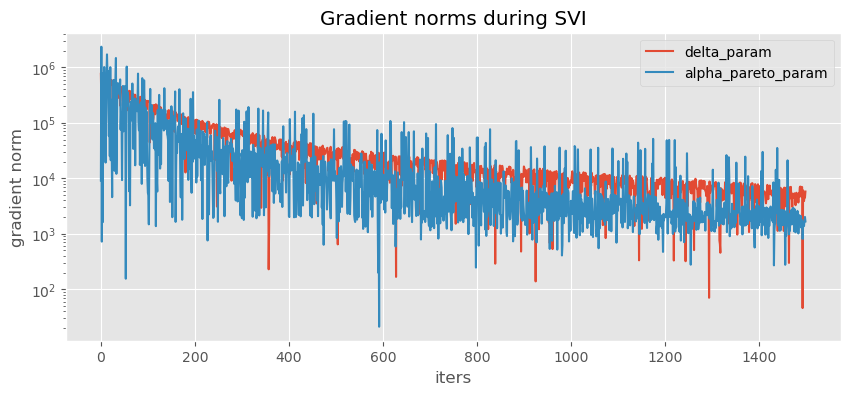

bic:  tensor(25610.5820, grad_fn=<RsubBackward1>)


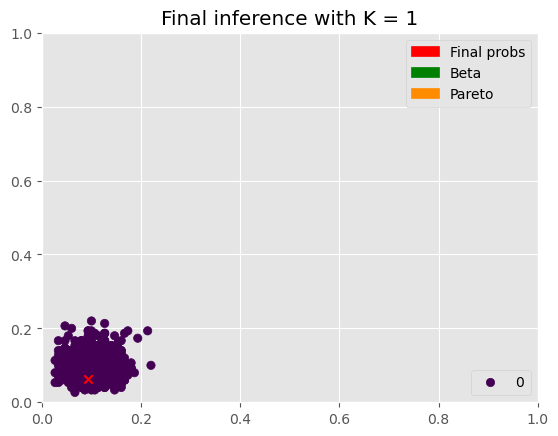

RUN WITH K =  2
Beta:  tensor([[1.9713, 2.4686],
        [1.5526, 2.2612]])
Pareto:  tensor([[-0.4797, -0.1501],
        [ 0.4733,  0.1310]])
Iteration 0: Loss = 7715677.5
weights_param tensor([0.7685, 0.2315], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9821, 0.9802],
        [0.9831, 0.9811]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.1633, 0.1006],
        [0.0466, 0.0753]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 98.0217, 102.0200],
        [102.0185, 102.0214]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3904, 0.6096],
         [0.3904, 0.6096]],

        [[0.3904, 0.6096],
         [0.3904, 0.6096]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 5950066.0
Iteration 400: Loss = 5906318.5
Iteration 600: Loss = 5877443.5
Iteration 800: Loss = 5876606.0
Iteration 1000: Loss = 5867725.0
Iteration 1200: Loss = 5866937.5
Iteration 1400: Loss = 5865331.0
phi_beta [[0.09836597 0.09881517]
 [0.12806489 0.15103152]]


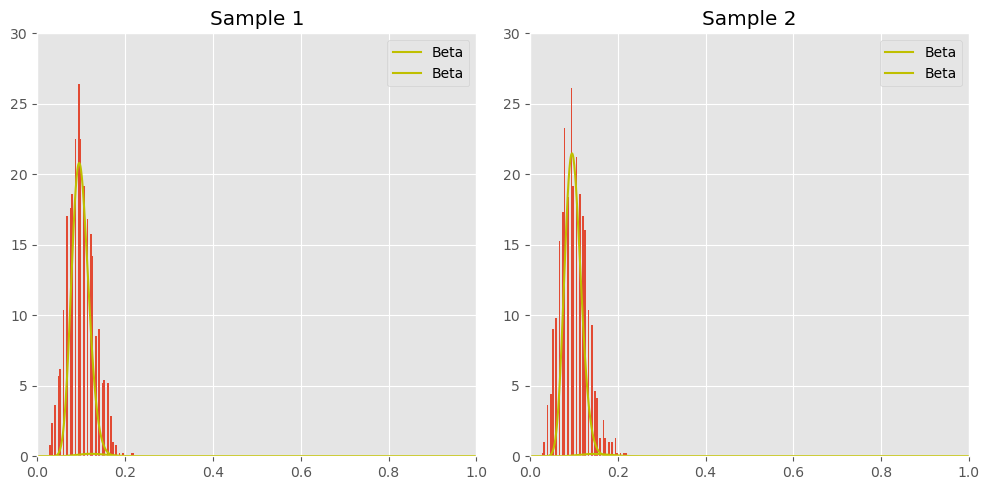

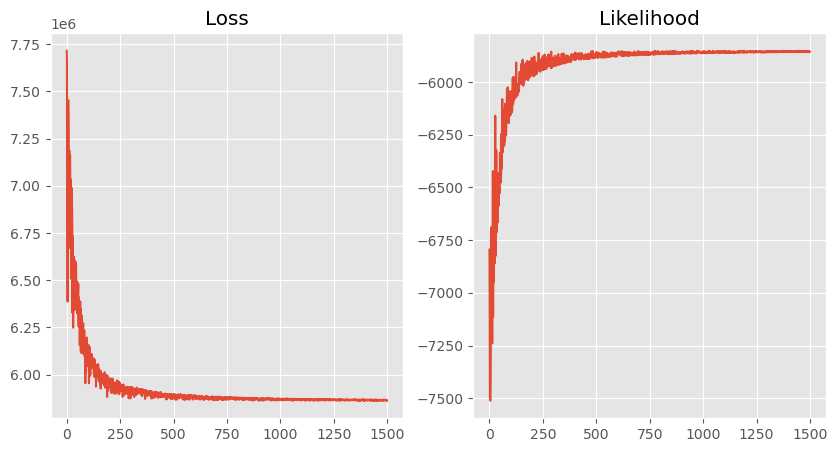

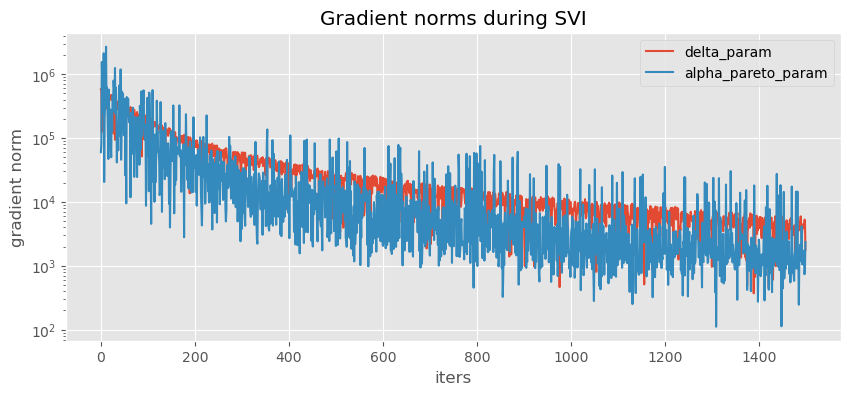

bic:  tensor(32587.4844, grad_fn=<RsubBackward1>)


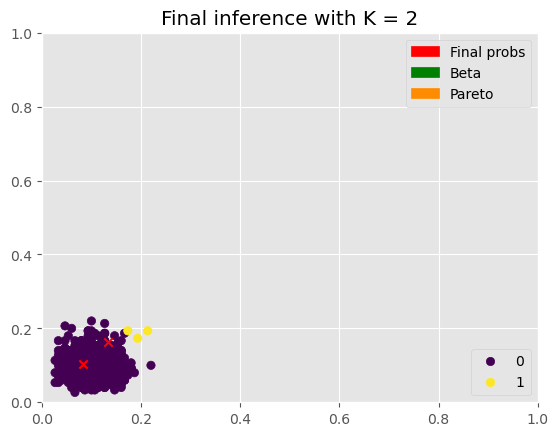

RUN WITH K =  3
Beta:  tensor([[1.9735, 2.5874],
        [1.6058, 2.2211],
        [2.4005, 1.8010]])
Pareto:  tensor([[ 0.3800,  0.5485],
        [ 0.3465, -0.5194],
        [-0.5809,  0.0256]])
Iteration 0: Loss = 7257154.5
weights_param tensor([0.2784, 0.2260, 0.4956], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9825, 0.9827],
        [0.9974, 0.9808],
        [0.9803, 0.9834]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.1194, 0.0683],
        [0.0519, 0.1118],
        [0.1472, 0.0686]], grad_fn=<AddBackward0>)
k_beta_param tensor([[102.0103,  98.2671],
        [102.0215, 101.9995],
        [ 98.0672,  98.1308]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3905, 0.6095],
         [0.3934, 0.6066]],

        [[0.3905, 0.6095],
         [0.3905, 0.6095]],

        [[0.3906, 0.6094],
         [0.3904, 0.6096]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 5961118.5
Iteration 400: Loss = 5886087.0
Iteration 600: Loss = 5884666.0
Iteration 800: Loss = 5872998.5
Ite

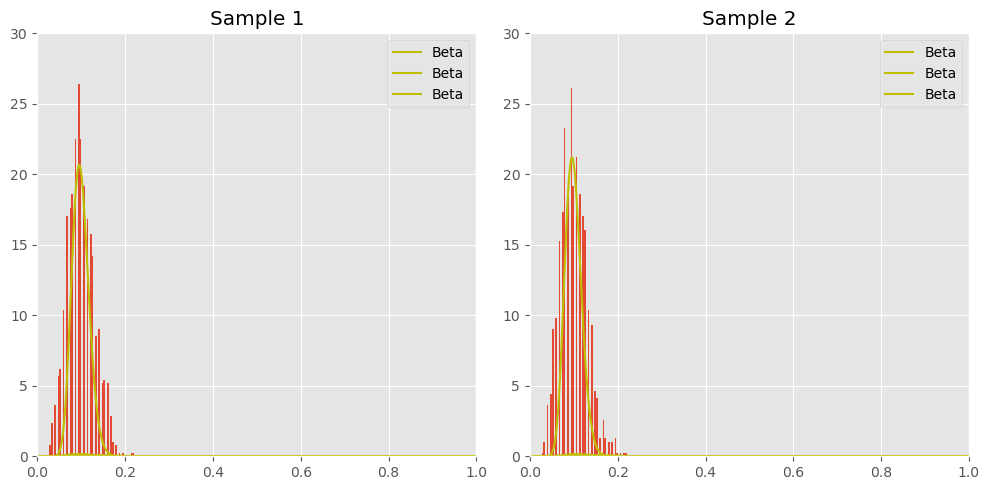

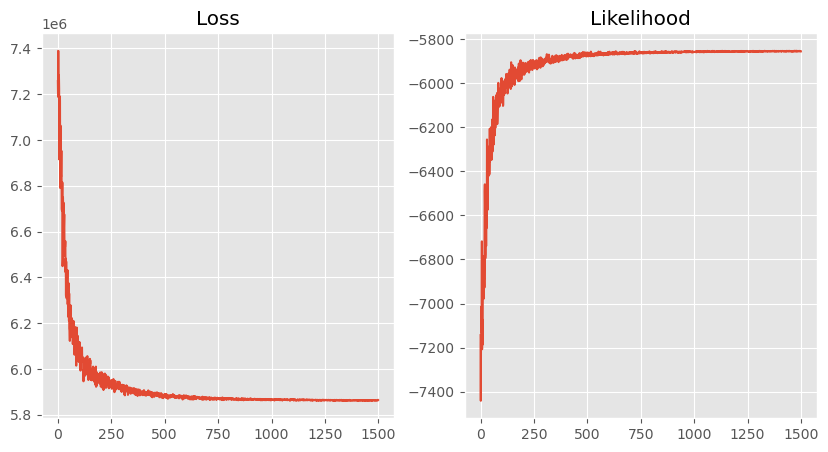

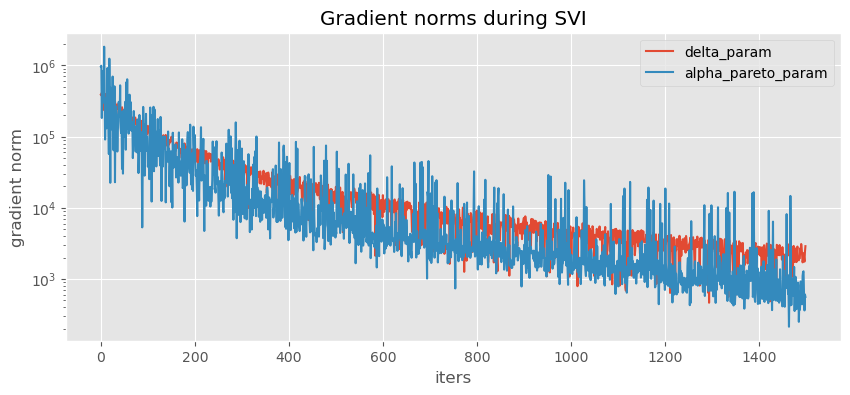

bic:  tensor(39568.5625, grad_fn=<RsubBackward1>)


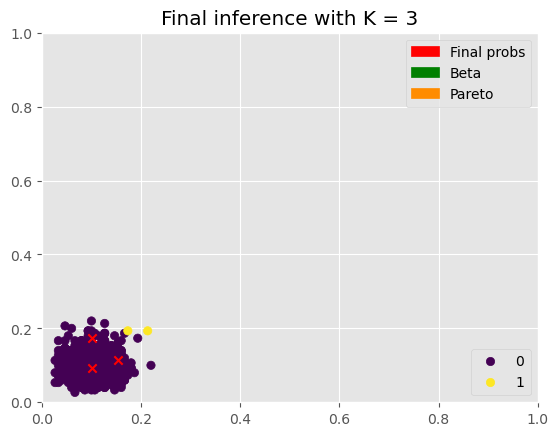

Selected number of clusters is:  1


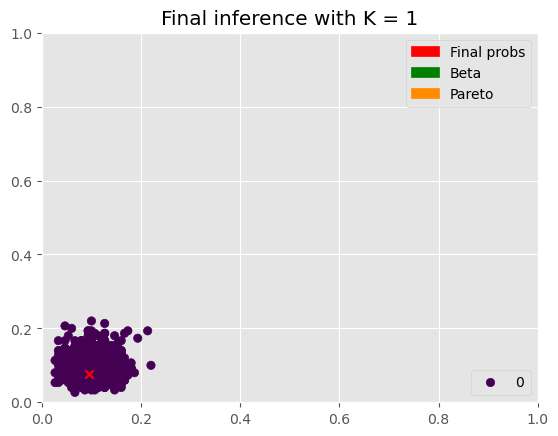

In [25]:
mb = model_mobster_mv.fit(NV, DP, num_iter = 1500, K = [1,2,3], seed = 53, lr = 0.01)

In [29]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(mb, beta = False, dim = 1, k = 0))

tensor(-2930.5579, grad_fn=<SumBackward0>)
tensor(-8410.1660, grad_fn=<SumBackward0>)
tensor(-2924.2002, grad_fn=<SumBackward0>)
tensor(-8511.3730, grad_fn=<SumBackward0>)


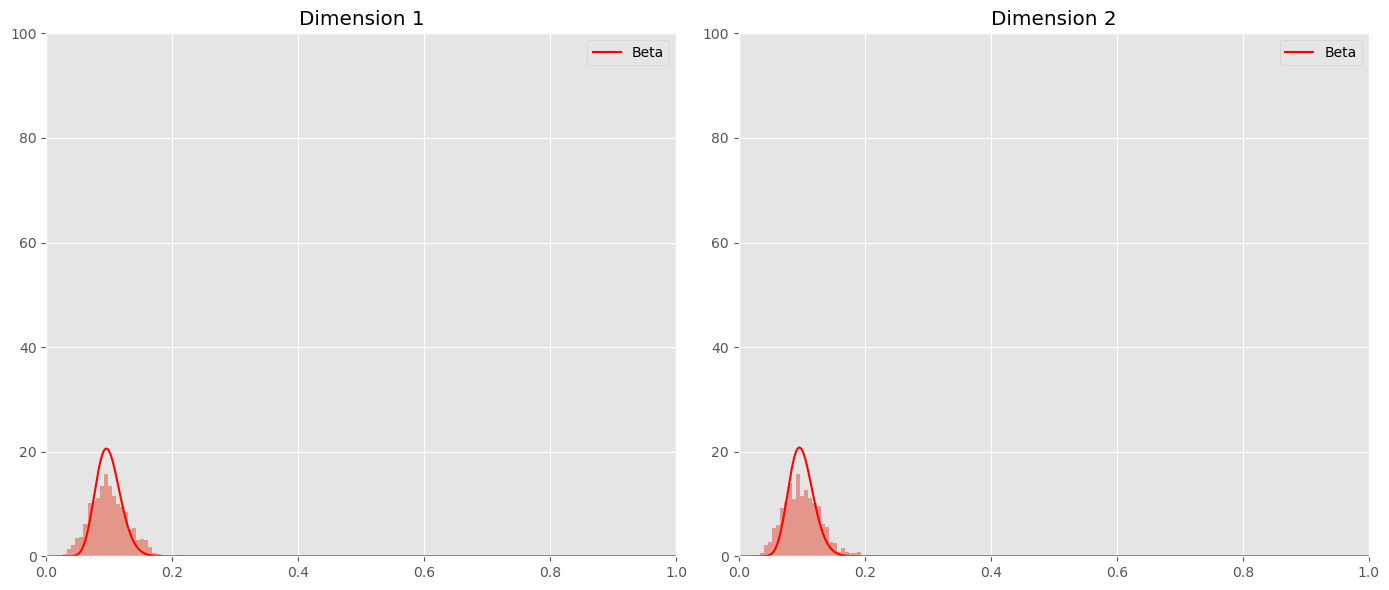

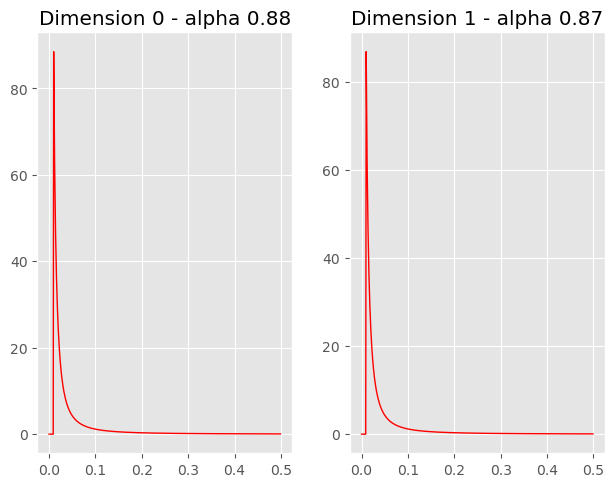

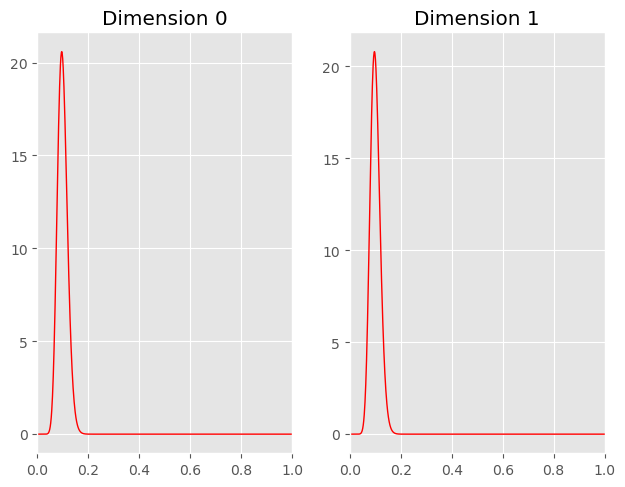

In [30]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [28]:
mb.params

{'weights_param': tensor([1.], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[0.8845, 0.8684]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.0987, 0.0995]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[231.3516, 237.9194]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.0038, 0.9962],
          [0.0036, 0.9964]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1.

### One pareto-pareto component

In [31]:
N1 = 1000
seed = 123

n1=100
NV, DP = only_pareto_binomial_component(alpha_x=2, L_x=0.01, H_x=0.5, alpha_y=2, L_y=0.01, H_y=0.5, n=n1, N=N1, seed = 123)

print(DP.shape)

torch.Size([1000, 2])


In [32]:
alpha = torch.tensor(2.)
pareto_mean = alpha*0.01/(alpha-1)
print(pareto_mean)
dim = 0
print("Pareto lk: ", log_sum_exp(pareto_lk(NV[:, dim], DP[:, dim], alpha)).sum())
phi_beta = pareto_mean
k_beta = torch.tensor(150.)
a_beta = phi_beta * k_beta
b_beta = (1-phi_beta) * k_beta
print("Beta lk: ", log_sum_exp(beta_lk(NV[:, dim], DP[:, dim], a_beta, b_beta)).sum())

tensor(0.0200)
Pareto lk:  tensor(-13039.0059)
Beta lk:  tensor(-1850.9456)


In [18]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0100)
tensor(0.0100)


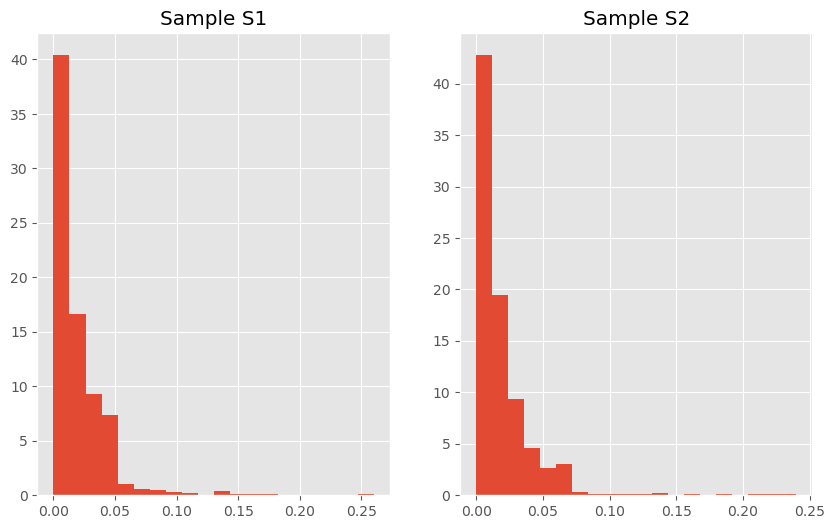

In [35]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), density = True, bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), density = True, bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [36]:
labels = np.zeros(N1)

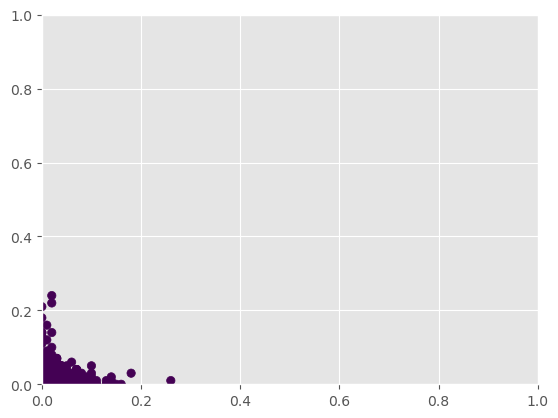

In [37]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K =  1
Beta:  tensor([[2.4853, 2.6693]])
Pareto:  tensor([[3.3152, 3.2736]])
Iteration 0: Loss = 3877502.75
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9803, 1.0125]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0100, 0.0100]], grad_fn=<AddBackward0>)
k_beta_param tensor([[98.0245, 98.0418]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.5984, 0.4016],
         [0.5918, 0.4082]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 3888457.25
Iteration 400: Loss = 3887305.75
Iteration 600: Loss = 3886267.75
Iteration 800: Loss = 3821224.5
Iteration 1000: Loss = 3768478.0
Iteration 1200: Loss = 3792349.5
Iteration 1400: Loss = 3803252.75
Iteration 1600: Loss = 3797362.0
Iteration 1800: Loss = 3975455.75
Iteration 2000: Loss = 3835375.75
Iteration 2200: Loss = 3912293.5
Iteration 2400: Loss = 3823613.0
Iteration 2600: Loss = 3874161.0
Iteration 2800: Loss = 3924759.5
phi_beta [[0.01 0.01]]


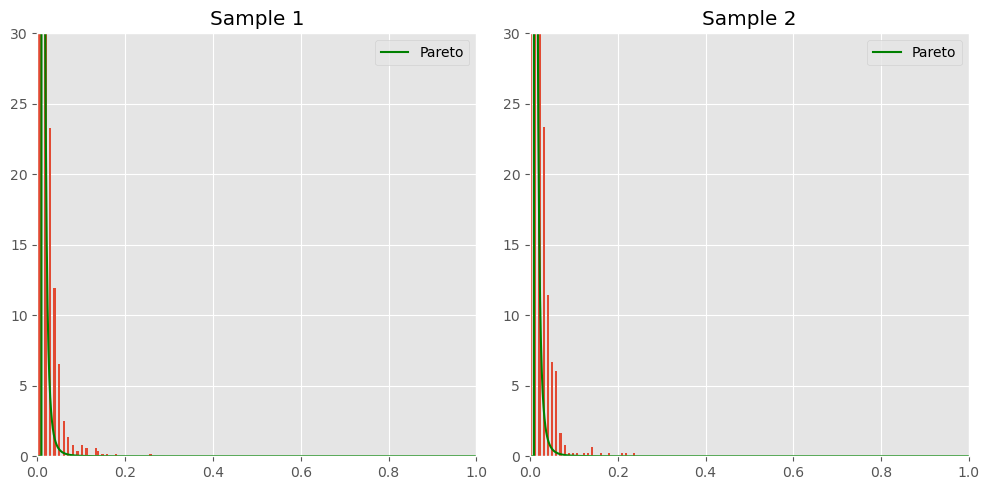

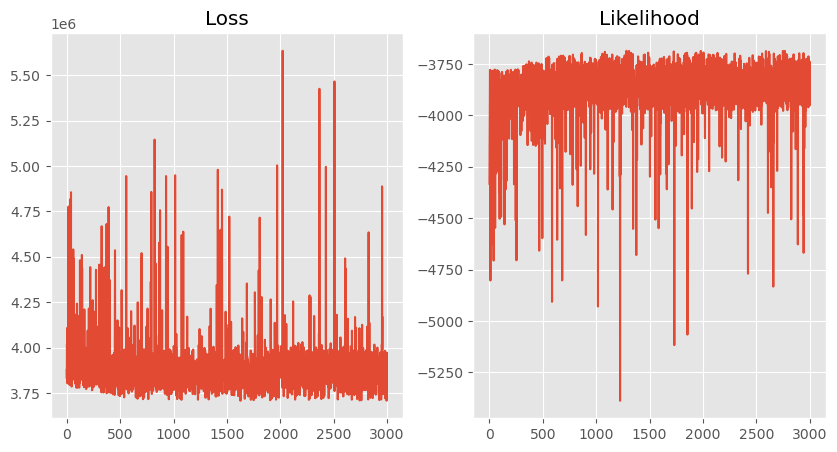

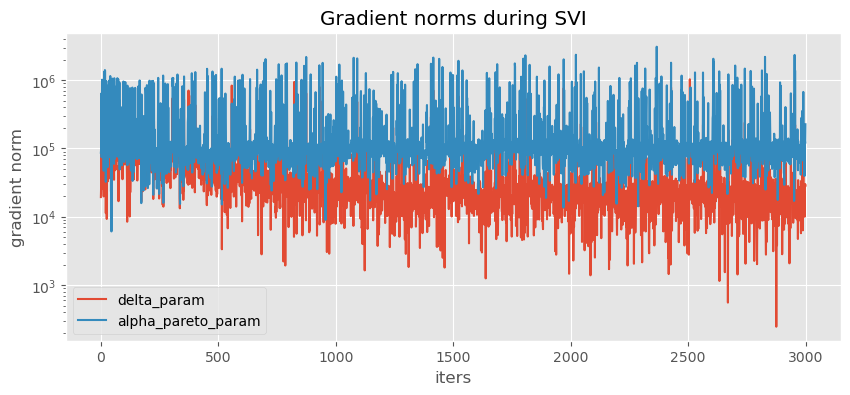

bic:  tensor(26499.9180, grad_fn=<RsubBackward1>)


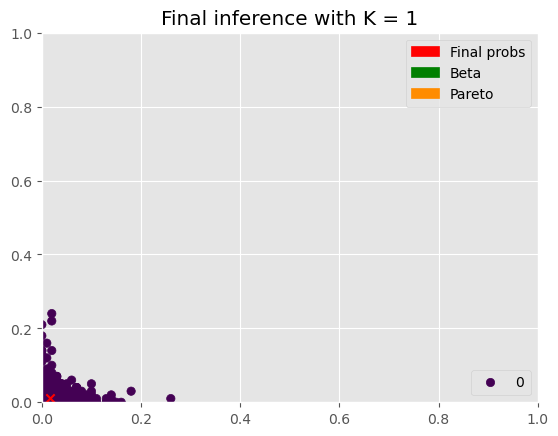

RUN WITH K =  2
Beta:  tensor([[2.5145, 3.3127],
        [3.3058, 2.5510]])
Pareto:  tensor([[3.2422, 4.0803],
        [3.8485, 1.0168]])
Iteration 0: Loss = 3763861.5
weights_param tensor([0.9290, 0.0710], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9969, 1.0165],
        [0.9835, 0.9825]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0100, 0.0100],
        [0.0119, 0.0815]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 98.2198, 101.7753],
        [ 98.6220,  98.3207]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.6025, 0.3975],
         [0.5923, 0.4077]],

        [[0.6082, 0.3918],
         [0.4069, 0.5931]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 3700552.5
Iteration 400: Loss = 3699460.75
Iteration 600: Loss = 3667737.25
Iteration 800: Loss = 3686304.75
Iteration 1000: Loss = 3669842.5
Iteration 1200: Loss = 3674715.25
Iteration 1400: Loss = 3684173.75
Iteration 1600: Loss = 3694086.25
Iteration 1800: Loss = 3676201.25
Iteration 2000: Loss = 3670294.75
I

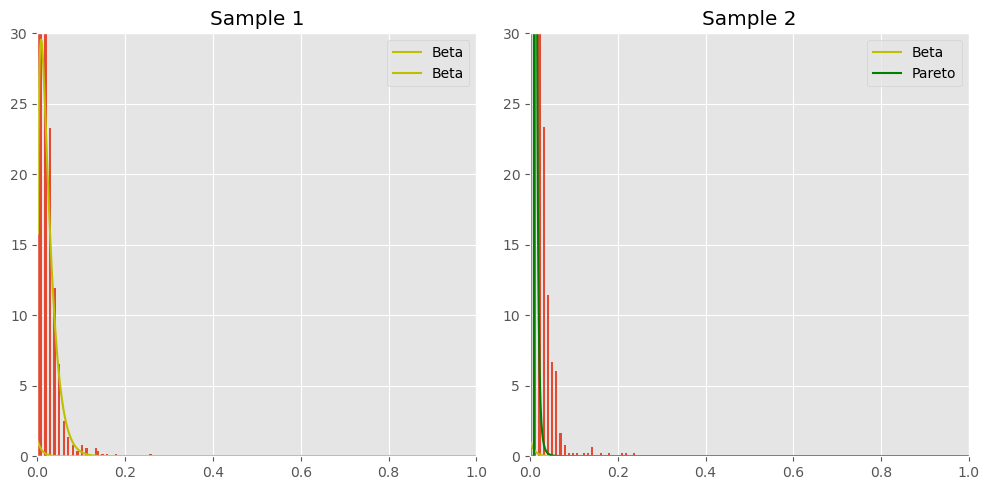

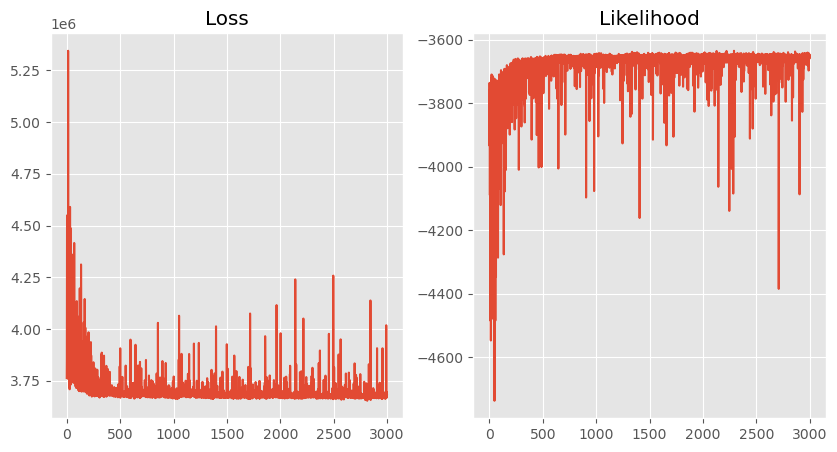

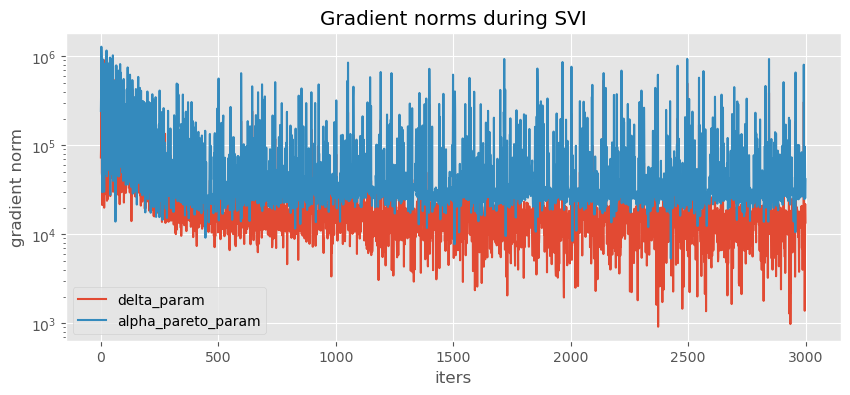

bic:  tensor(30728.7910, grad_fn=<RsubBackward1>)


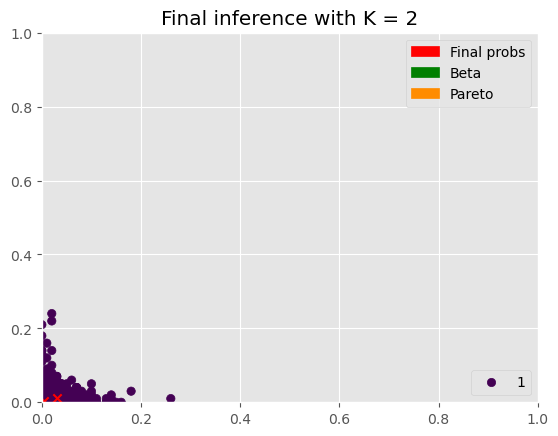

RUN WITH K =  3
Beta:  tensor([[ 1.7227, -1.5319],
        [ 3.3393,  2.6775],
        [ 1.8835,  3.0701]])
Pareto:  tensor([[4.0874, 1.0016],
        [4.1199, 4.1135],
        [1.0563, 3.7363]])
Iteration 0: Loss = 4297020.5
weights_param tensor([0.1324, 0.2394, 0.6282], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0175, 1.0168],
        [1.0177, 1.0197],
        [1.0168, 0.9973]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0100, 0.0100],
        [0.0100, 0.0349],
        [0.0968, 0.0100]], grad_fn=<AddBackward0>)
k_beta_param tensor([[102.0129, 102.0213],
        [101.8381,  98.1167],
        [ 98.0186, 101.9155]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.5910, 0.4090],
         [0.5922, 0.4078]],

        [[0.5962, 0.4038],
         [0.6018, 0.3982]],

        [[0.4088, 0.5912],
         [0.6023, 0.3977]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 3668888.5
Iteration 400: Loss = 3679380.25
Iteration 600: Loss = 3668022.0
Iteration 800: Loss = 3670959.25
I

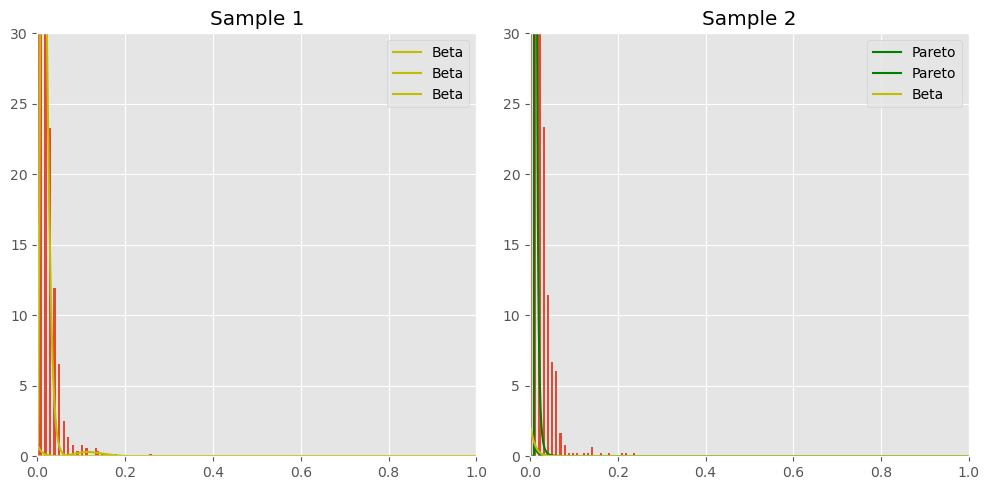

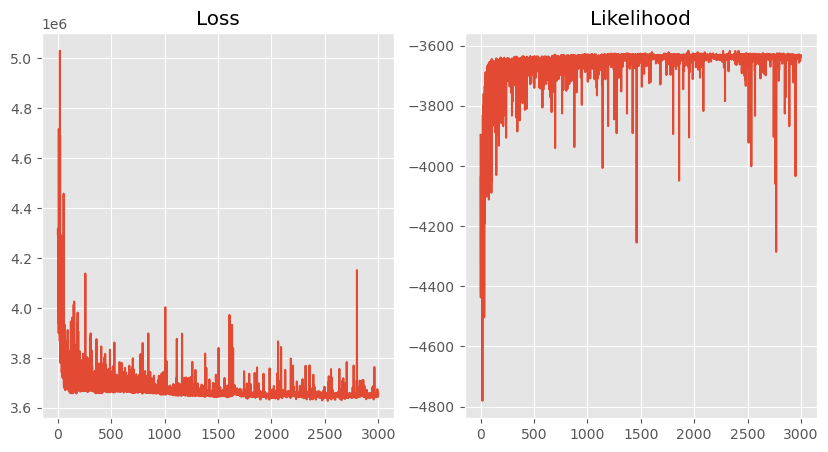

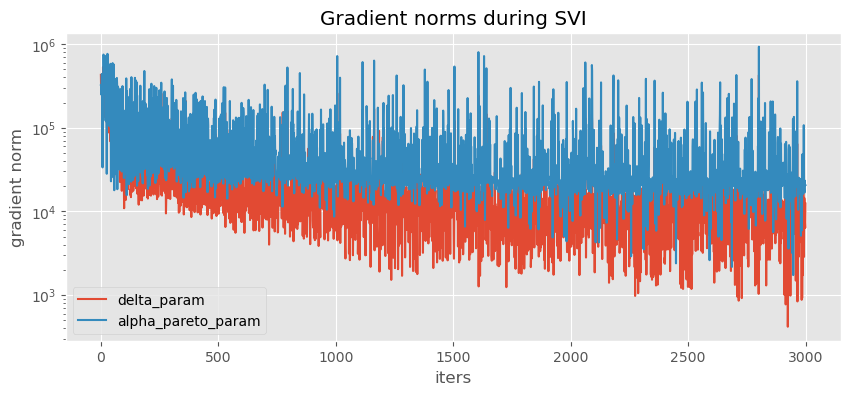

bic:  tensor(36483.3750, grad_fn=<RsubBackward1>)


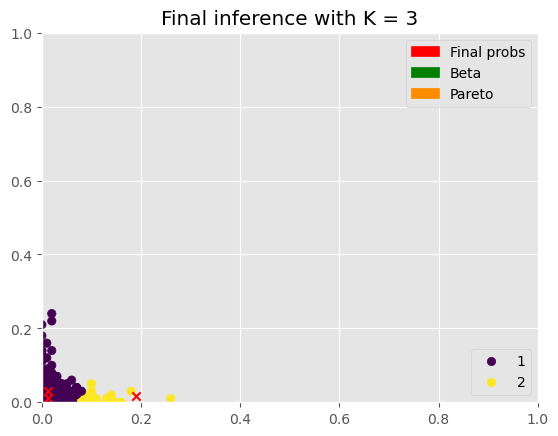

Selected number of clusters is:  1


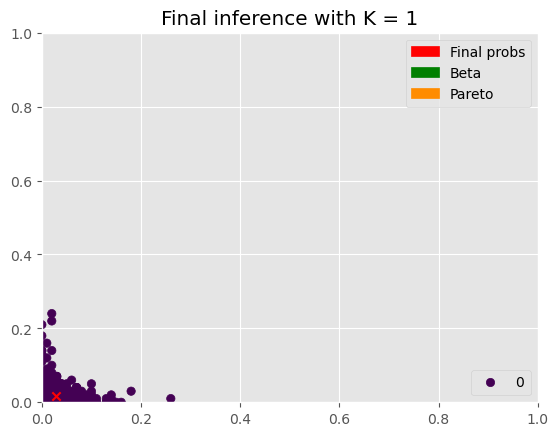

In [38]:
mb = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [1,2,3], seed = 12, lr = 0.01)

In [39]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(mb, beta = False, dim = 1, k = 0))

tensor(-2135.6104, grad_fn=<SumBackward0>)
tensor(-13037.2051, grad_fn=<SumBackward0>)
tensor(-2185.4619, grad_fn=<SumBackward0>)
tensor(-13103.6348, grad_fn=<SumBackward0>)


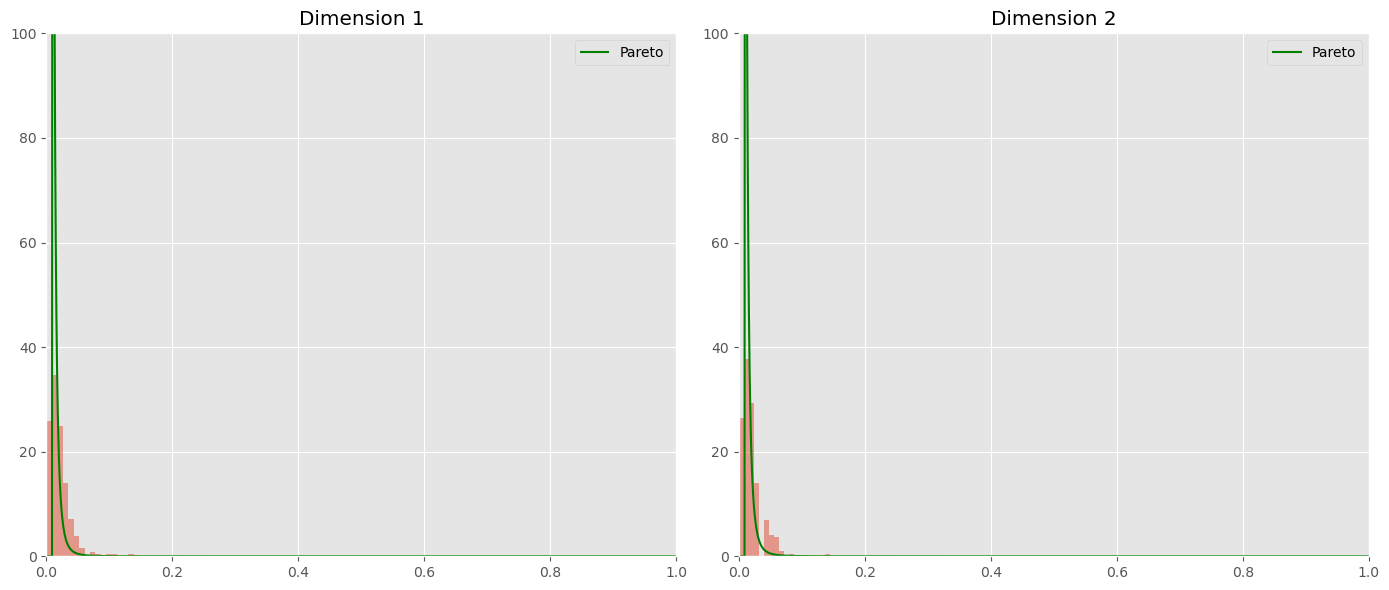

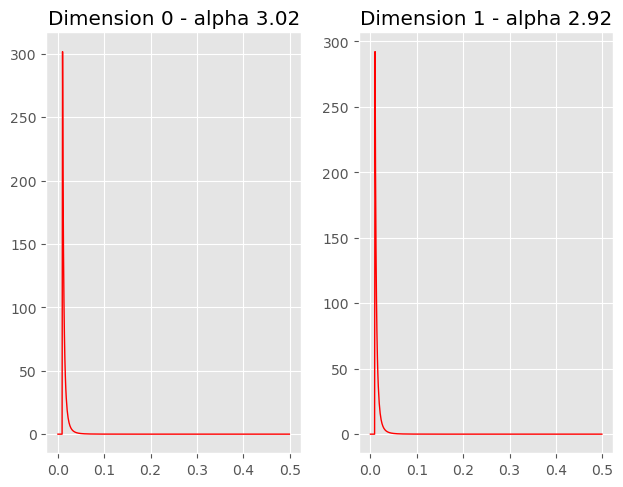

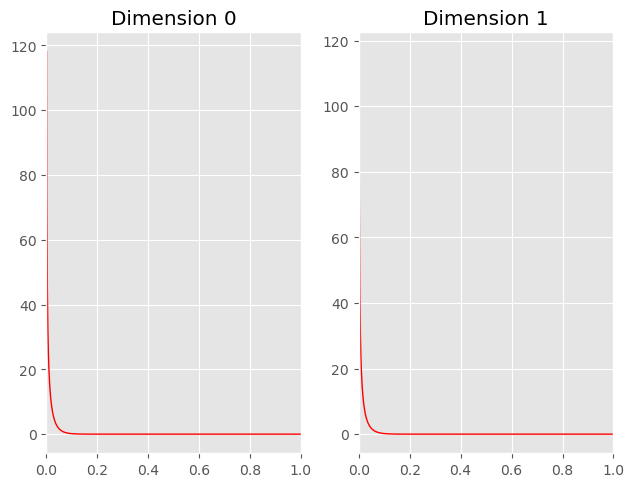

In [40]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [41]:
mb.params

{'weights_param': tensor([1.], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[3.0163, 2.9202]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.0100, 0.0100]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[37.6381, 34.9225]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.7057, 0.2943],
          [0.7410, 0.2590]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

### One beta-pareto component

In [46]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.1
k_beta = 200
n1 = 100
NV, DP = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

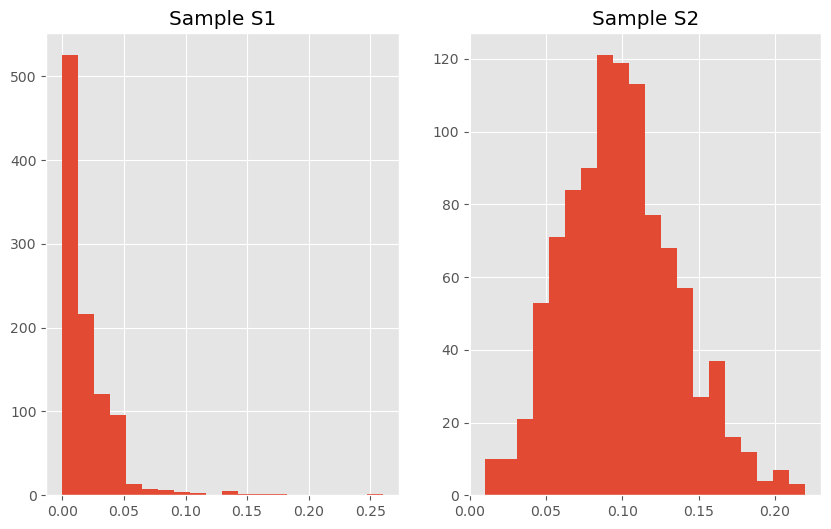

In [47]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [48]:
labels = np.zeros(N1)

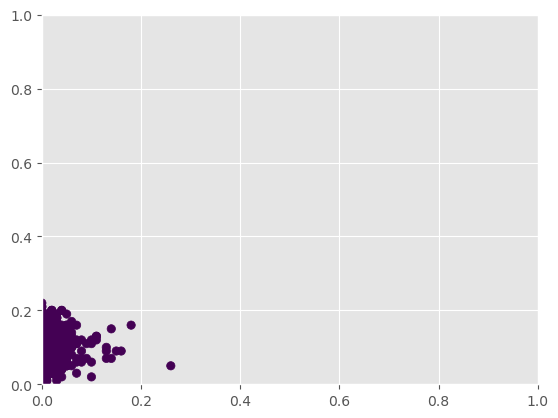

In [49]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K =  1
Beta:  tensor([[2.7092, 2.1301]])
Pareto:  tensor([[ 3.3152, -0.0046]])
Iteration 0: Loss = 5249475.0
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0157, 0.9833]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0100, 0.1321]], grad_fn=<AddBackward0>)
k_beta_param tensor([[101.1105, 101.3093]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.5920, 0.4080],
         [0.3909, 0.6091]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 4637406.5
Iteration 400: Loss = 4577895.0
Iteration 600: Loss = 4626895.0
Iteration 800: Loss = 4600629.0
Iteration 1000: Loss = 4658377.5
Iteration 1200: Loss = 4638305.0
Iteration 1400: Loss = 4591050.0
Iteration 1600: Loss = 4607475.0
Iteration 1800: Loss = 4643462.0
Iteration 2000: Loss = 4620513.0
Iteration 2200: Loss = 4647395.5
Iteration 2400: Loss = 4560366.5
Iteration 2600: Loss = 4641372.0
Iteration 2800: Loss = 4552157.0
phi_beta [[0.01       0.10054395]]


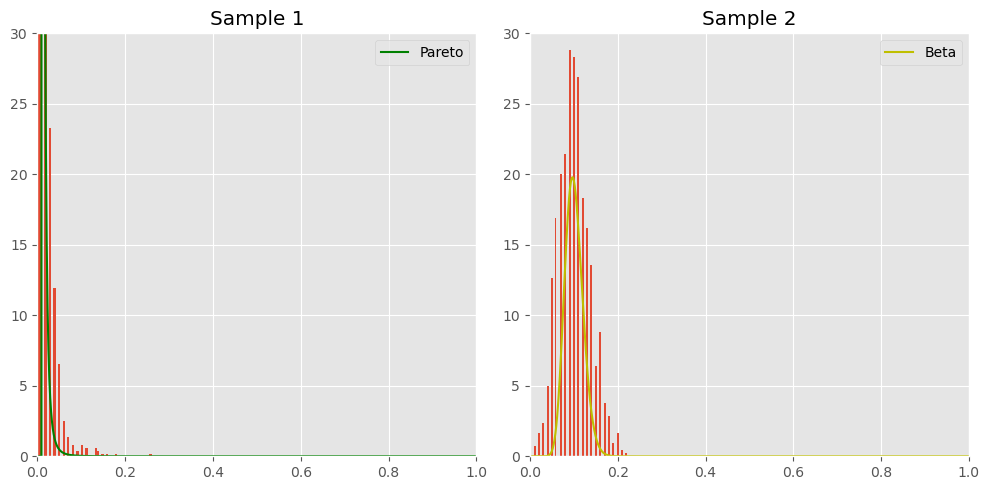

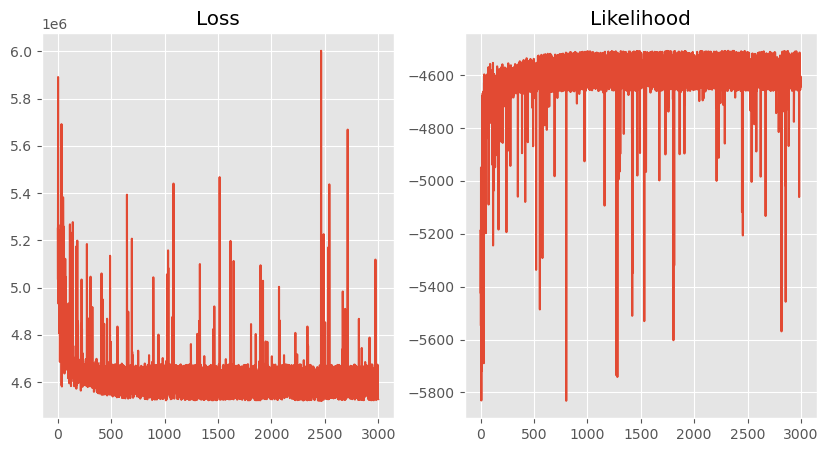

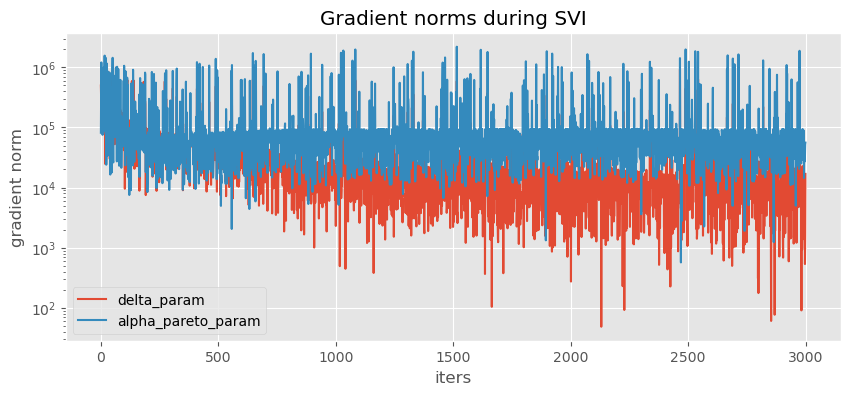

bic:  tensor(25462.4844, grad_fn=<RsubBackward1>)


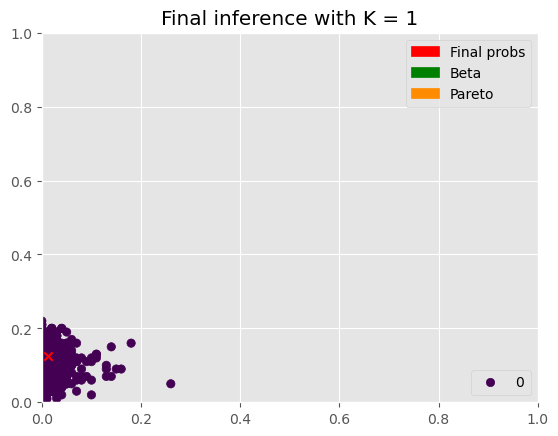

RUN WITH K =  2
Beta:  tensor([[2.6248, 2.0898],
        [2.7706, 1.6485]])
Pareto:  tensor([[ 3.2284, -0.5756],
        [ 3.3807,  0.5450]])
Iteration 0: Loss = 5673159.0
weights_param tensor([0.7060, 0.2940], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0202, 0.9827],
        [1.0196, 0.9810]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0100, 0.1649],
        [0.0100, 0.1199]], grad_fn=<AddBackward0>)
k_beta_param tensor([[101.8949,  98.0827],
        [101.8009, 101.9322]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.5909, 0.4091],
         [0.3908, 0.6092]],

        [[0.6095, 0.3905],
         [0.3904, 0.6096]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 4641863.5
Iteration 400: Loss = 4607496.0
Iteration 600: Loss = 4593790.5
Iteration 800: Loss = 4572999.0
Iteration 1000: Loss = 4541937.0
Iteration 1200: Loss = 4529795.0
Iteration 1400: Loss = 4566710.5
Iteration 1600: Loss = 4530735.0
Iteration 1800: Loss = 4545651.5
Iteration 2000: Loss = 4619406.0
Itera

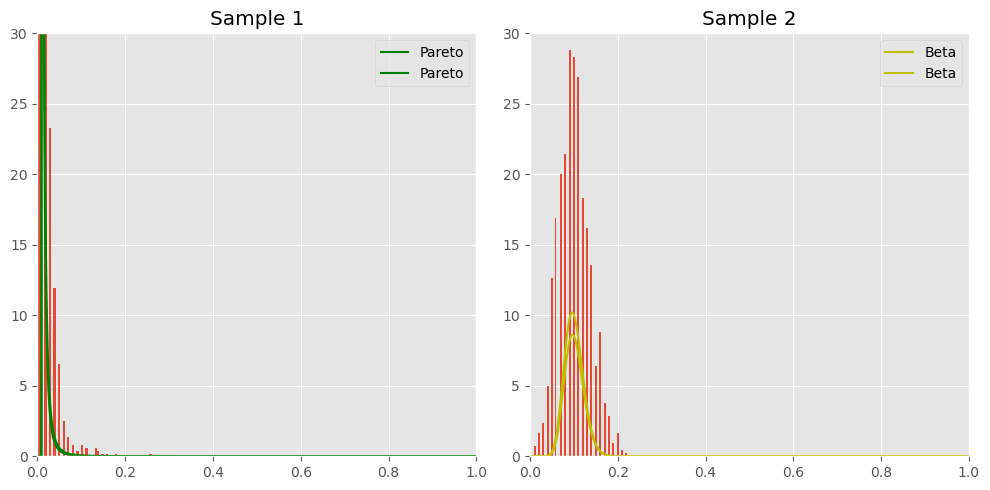

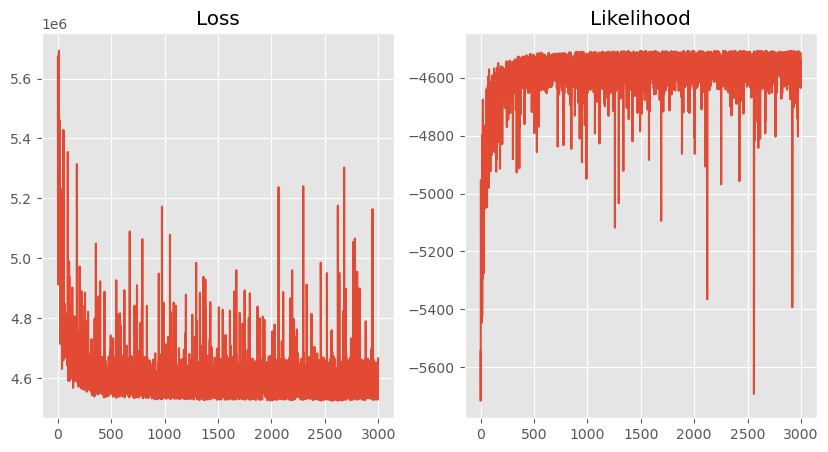

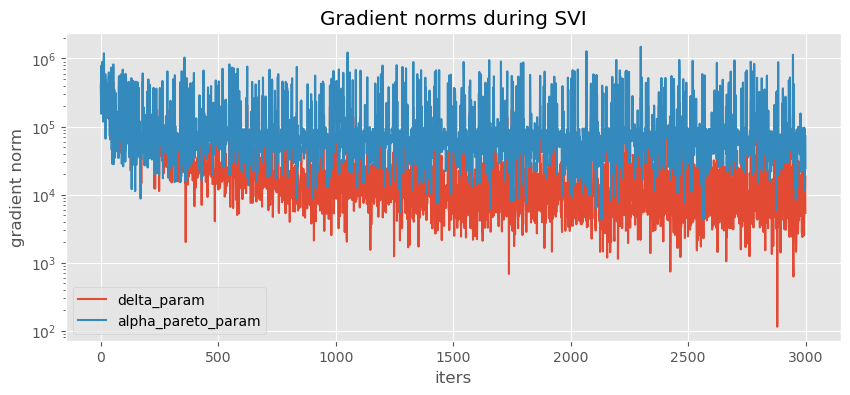

bic:  tensor(32734.8750, grad_fn=<RsubBackward1>)


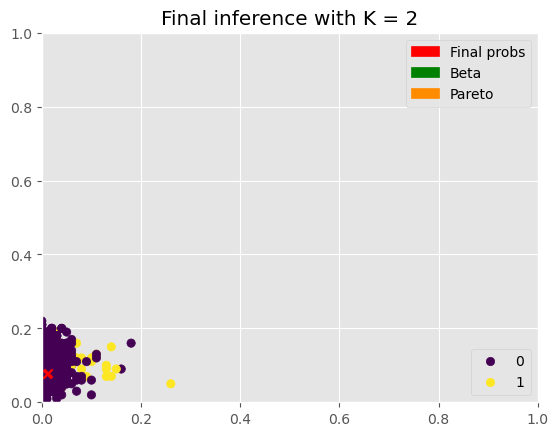

RUN WITH K =  3
Beta:  tensor([[ 2.6966,  2.1265],
        [ 2.7332,  1.5739],
        [-0.4725,  2.4095]])
Pareto:  tensor([[ 3.3020, -0.0668],
        [ 3.3405,  0.9294],
        [ 3.3029, -0.8005]])
Iteration 0: Loss = 5452075.5
weights_param tensor([0.0123, 0.0892, 0.8985], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0158, 0.9824],
        [1.0165, 0.9825],
        [1.0168, 0.9827]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0100, 0.1353],
        [0.0100, 0.1069],
        [0.0715, 0.1543]], grad_fn=<AddBackward0>)
k_beta_param tensor([[101.9937, 100.6673],
        [101.9930, 101.8894],
        [ 98.1662,  98.0506]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.5937, 0.4063],
         [0.3916, 0.6084]],

        [[0.5928, 0.4072],
         [0.3919, 0.6081]],

        [[0.5971, 0.4029],
         [0.3906, 0.6094]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 4549044.0
Iteration 400: Loss = 4509138.5
Iteration 600: Loss = 4543360.5
Iteration 800: Loss = 4510277

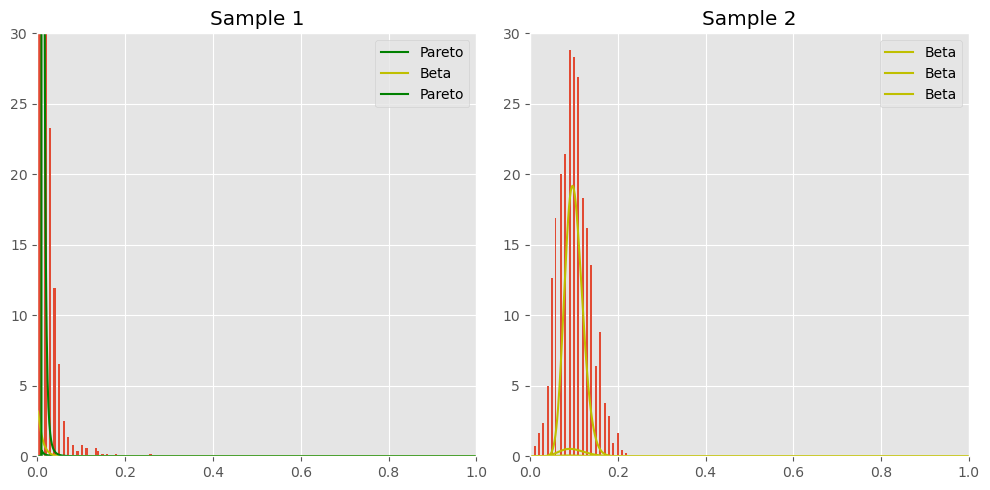

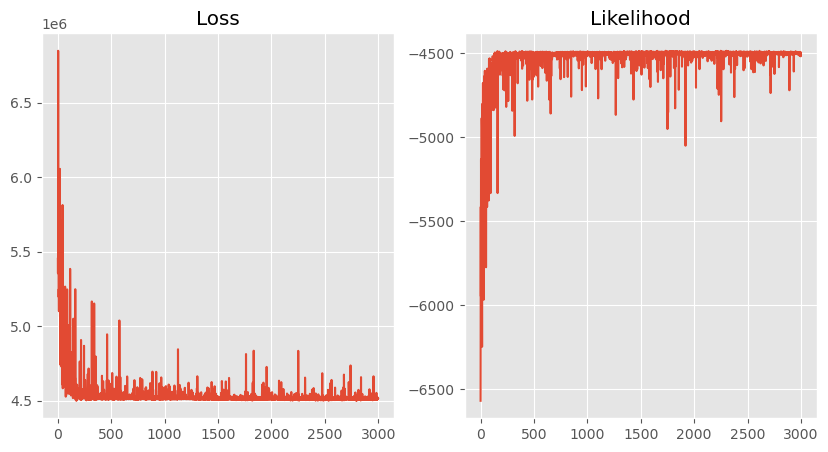

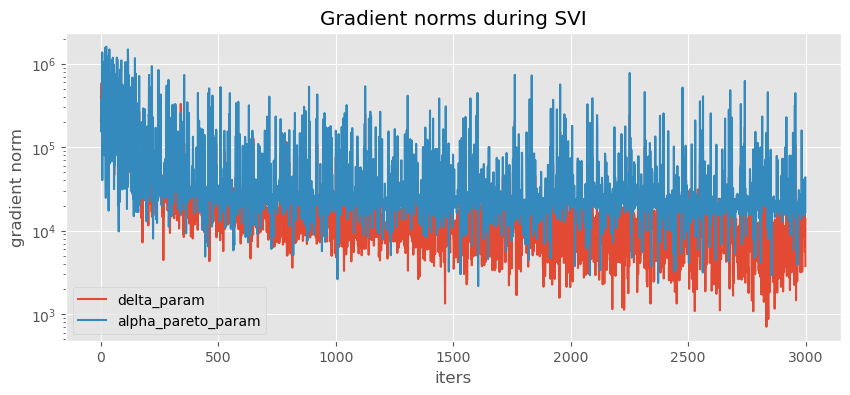

bic:  tensor(38124.2422, grad_fn=<RsubBackward1>)


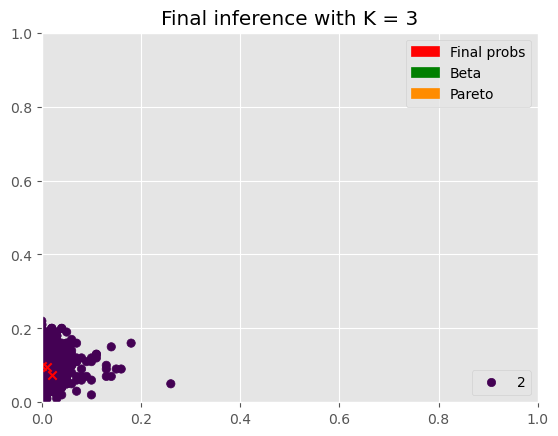

Selected number of clusters is:  1


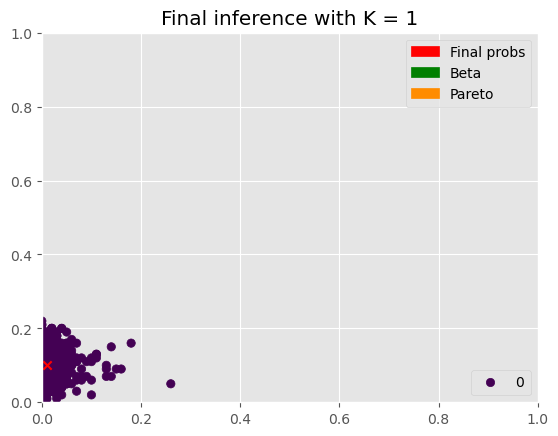

In [50]:
mb = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [1,2,3], seed = 15, lr = 0.01)

In [51]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0)) # x axis, beta
print(compute_likelihood(mb, beta = False, dim = 0, k = 0)) # x axis, pareto
print(compute_likelihood(mb, beta = True, dim = 1, k = 0)) # y axis, beta
print(compute_likelihood(mb, beta = False, dim = 1, k = 0)) # y axis, pareto

tensor(-2136.6680, grad_fn=<SumBackward0>)
tensor(-13037.1807, grad_fn=<SumBackward0>)
tensor(-2675.0173, grad_fn=<SumBackward0>)
tensor(-6514.9199, grad_fn=<SumBackward0>)


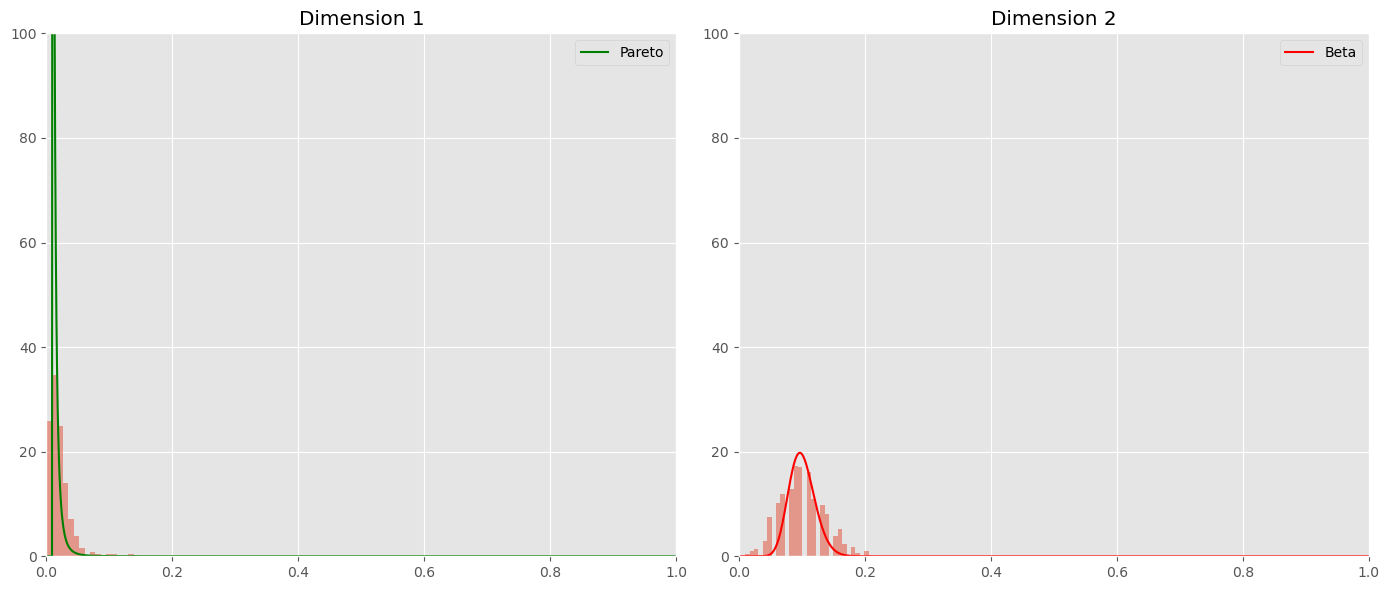

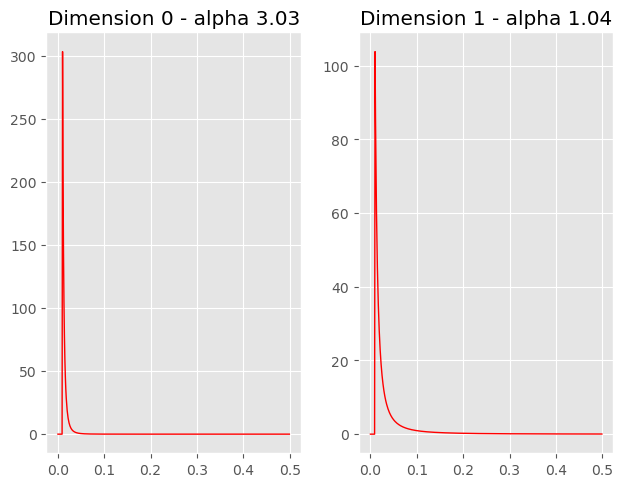

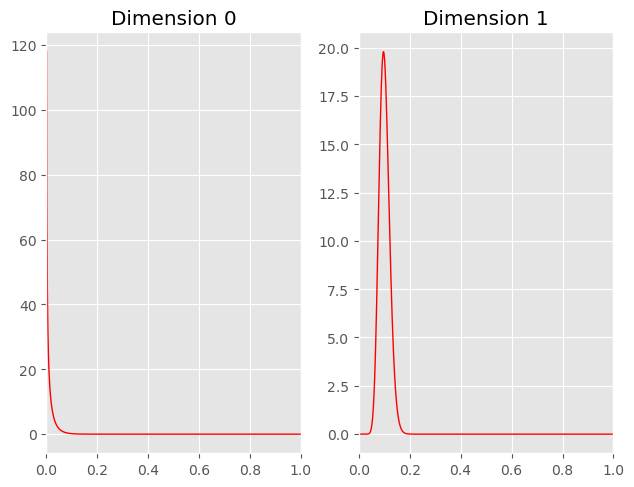

In [52]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [53]:
mb.params

{'weights_param': tensor([1.], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[3.0313, 1.0383]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.0100, 0.1005]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[ 37.4746, 216.9175]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.7137, 0.2863],
          [0.0029, 0.9971]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1.

### 2 beta-pareto components

In [5]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.2
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Sample S2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([1500, 2])
torch.Size([1500, 2])


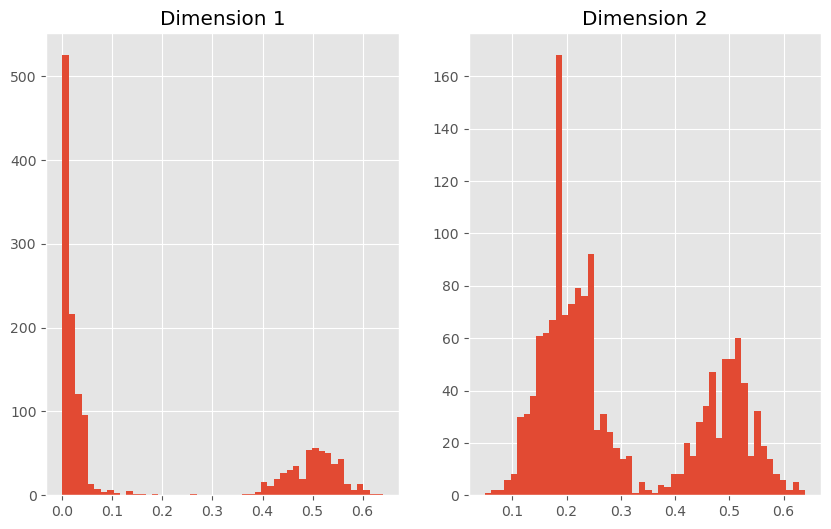

In [6]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [7]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

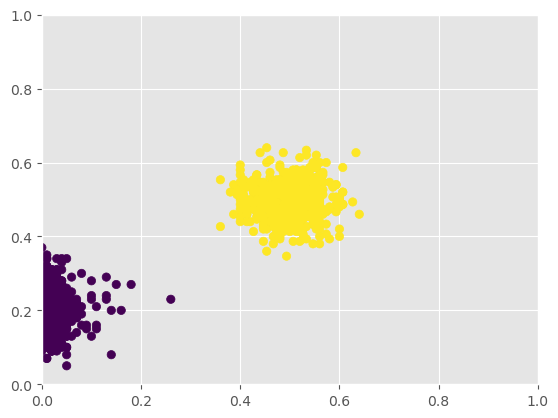

In [8]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K =  2
Beta:  tensor([[2.7092, 2.0101],
        [1.9243, 1.6554]])
Pareto:  tensor([[ 3.3151, -1.3964],
        [-3.2269, -3.2100]])
Iteration 0: Loss = 17301394.0
weights_param tensor([0.7061, 0.2939], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0200, 0.9827],
        [1.0031, 0.9812]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0100, 0.2321],
        [0.4760, 0.5432]], grad_fn=<AddBackward0>)
k_beta_param tensor([[101.9809,  98.0820],
        [102.0212,  98.0390]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.5908, 0.4092],
         [0.3904, 0.6096]],

        [[0.3904, 0.6096],
         [0.3904, 0.6096]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 14974768.0
Iteration 400: Loss = 14126018.0
Iteration 600: Loss = 13989668.0
Iteration 800: Loss = 14138012.0
Iteration 1000: Loss = 13966708.0
Iteration 1200: Loss = 14077194.0
Iteration 1400: Loss = 14117971.0
Iteration 1600: Loss = 14140053.0
Iteration 1800: Loss = 14098661.0
Iteration 2000: Loss = 14072

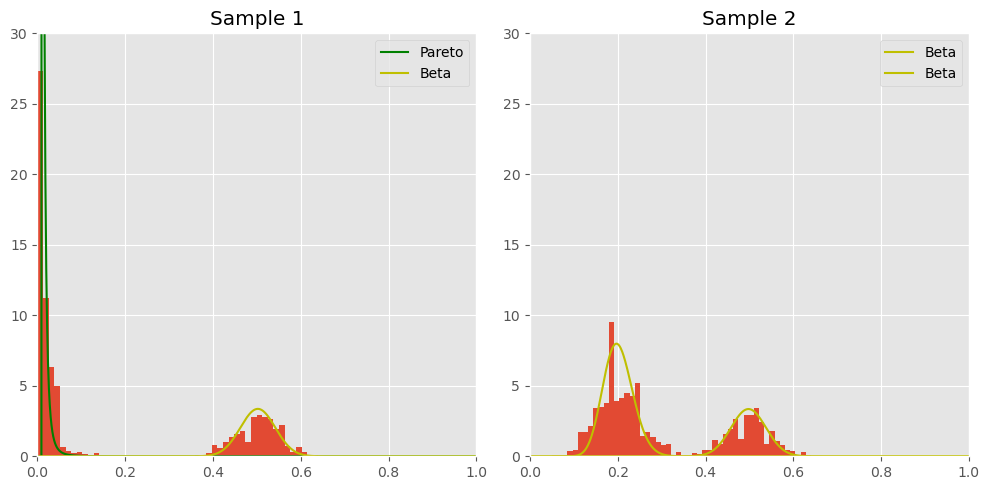

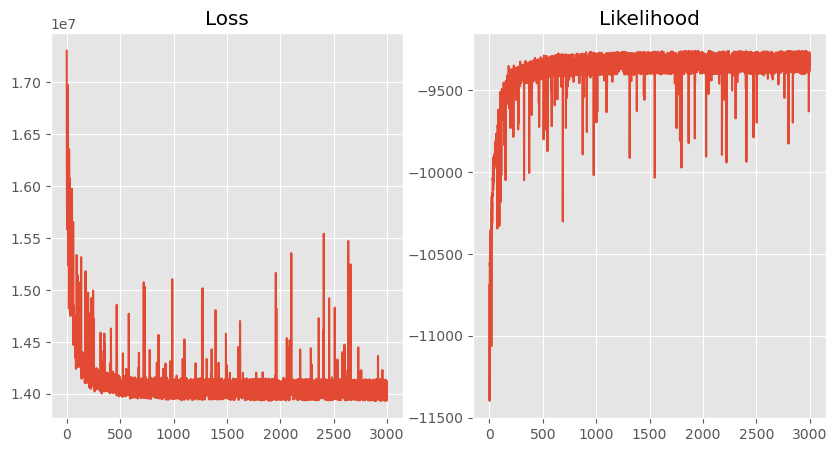

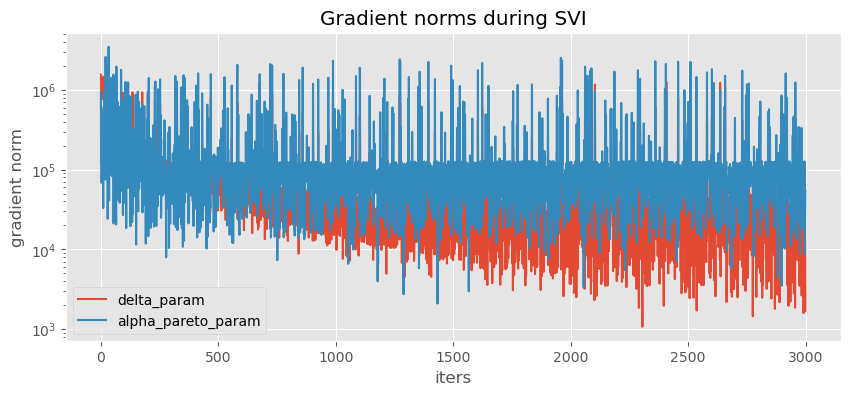

bic:  tensor(53395.5078, grad_fn=<RsubBackward1>)


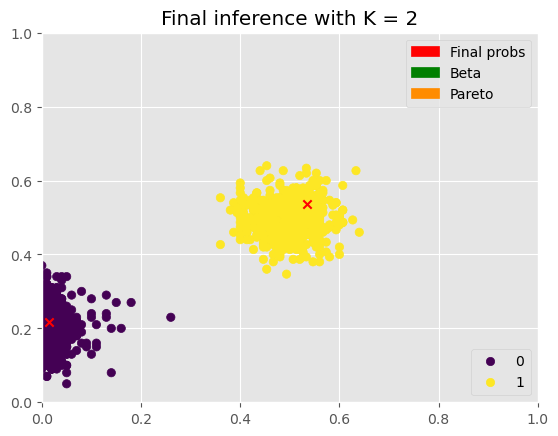

RUN WITH K =  3
Beta:  tensor([[ 2.6790,  1.9681],
        [ 1.9243,  1.6554],
        [-0.5103,  2.3686]])
Pareto:  tensor([[ 3.2836, -1.7863],
        [-3.2269, -3.2100],
        [ 3.3418, -1.0001]])
Iteration 0: Loss = 16670183.0
weights_param tensor([0.0123, 0.0894, 0.8983], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0167, 0.9826],
        [1.0123, 0.9827],
        [1.0168, 0.9841]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0100, 0.2757],
        [0.4760, 0.5432],
        [0.0712, 0.1743]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 98.5731, 102.0215],
        [102.0200,  98.0279],
        [ 98.2696, 101.9466]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.5921, 0.4079],
         [0.3916, 0.6084]],

        [[0.3904, 0.6096],
         [0.3904, 0.6096]],

        [[0.5955, 0.4045],
         [0.3904, 0.6096]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 14047268.0
Iteration 400: Loss = 14446113.0
Iteration 600: Loss = 13917144.0
Iteration 800: Loss = 139

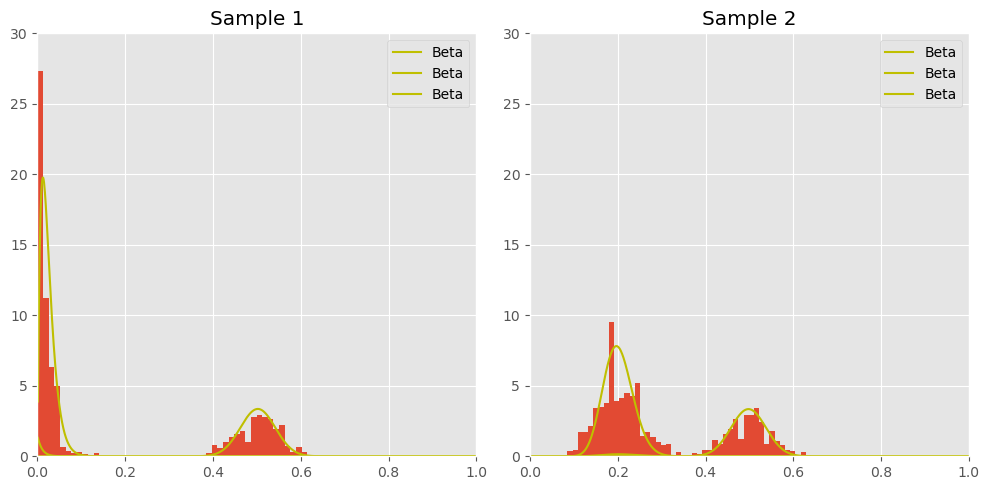

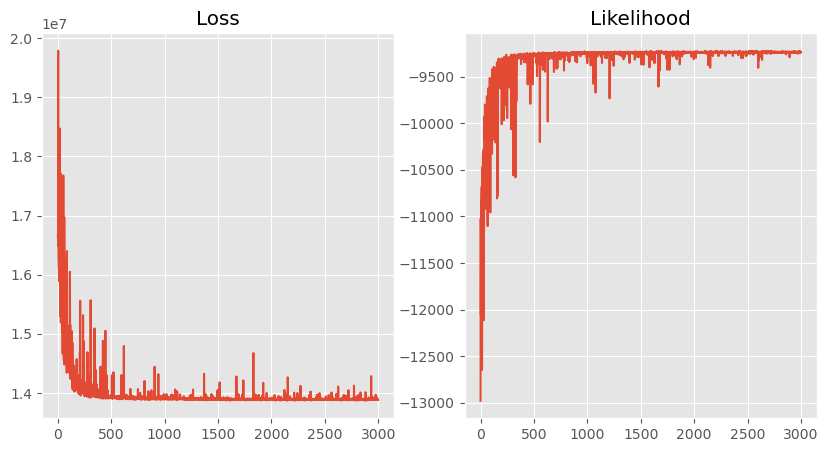

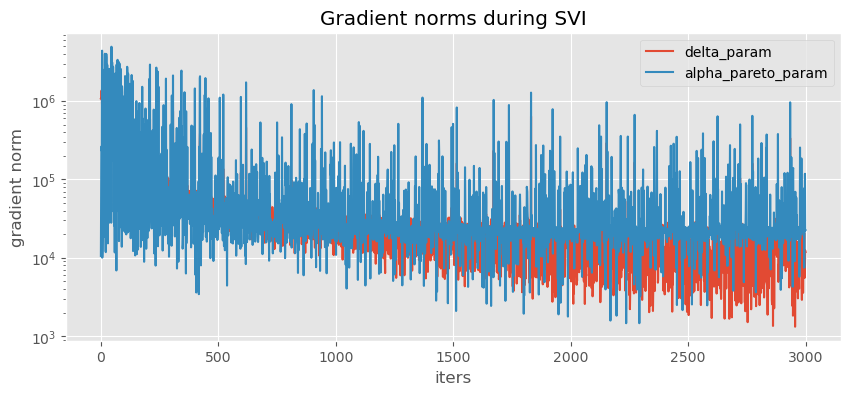

bic:  tensor(63622.7539, grad_fn=<RsubBackward1>)


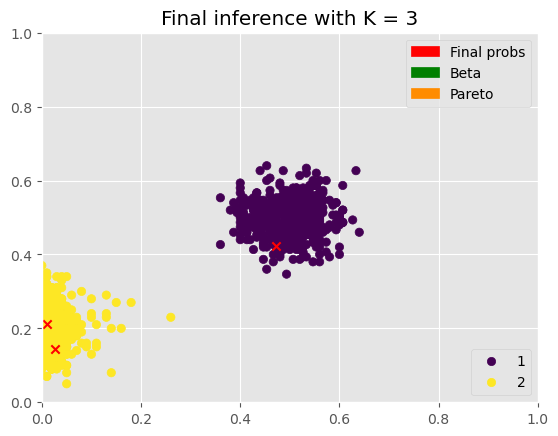

Selected number of clusters is:  2


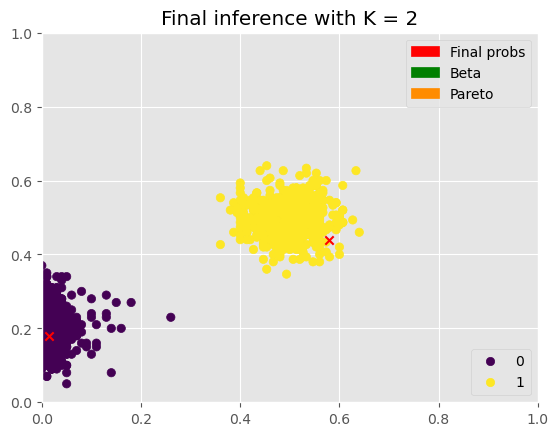

In [9]:
mb = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [2,3], seed = 15, lr = 0.01)

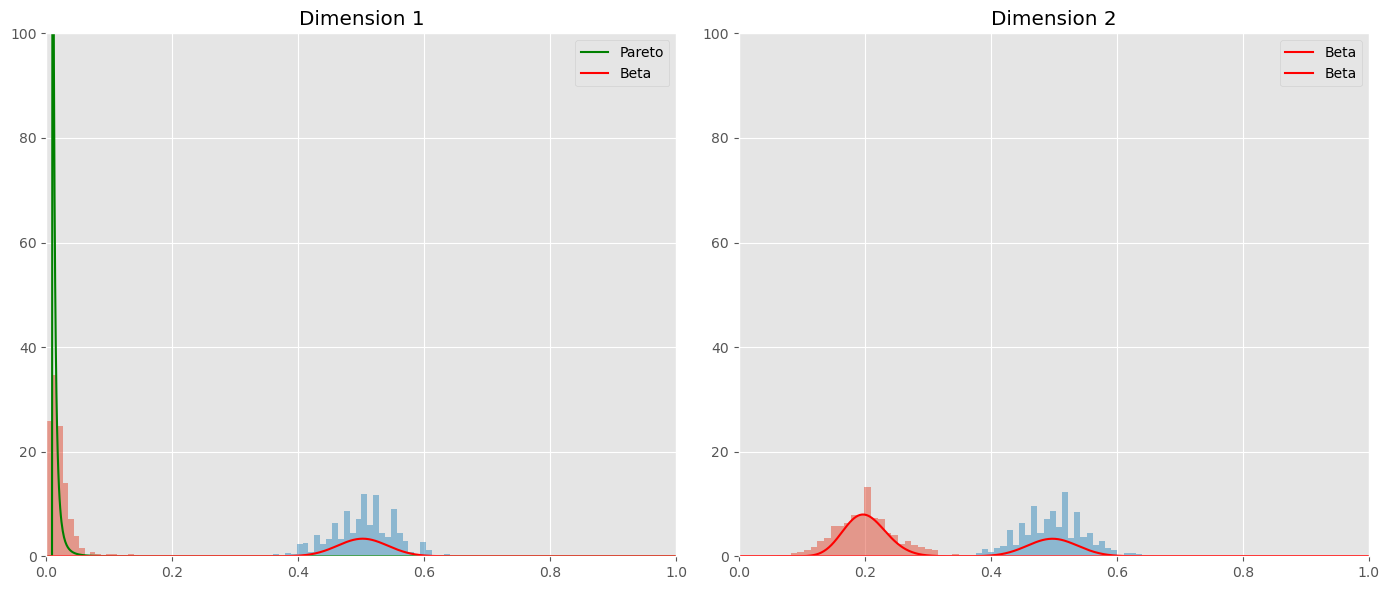

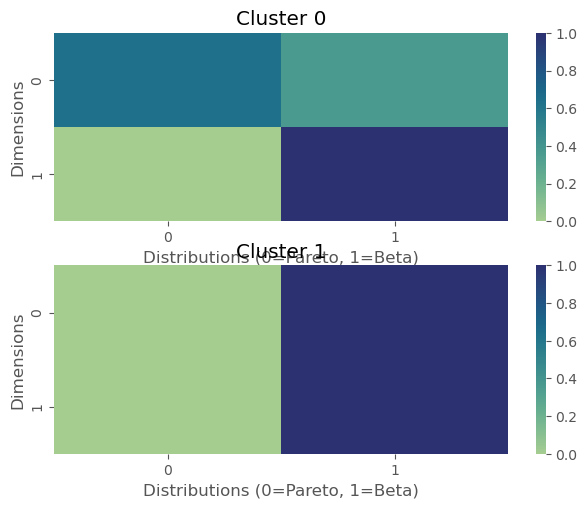

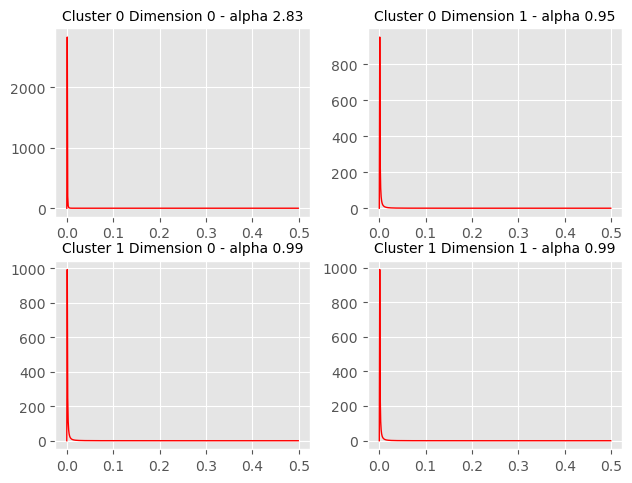

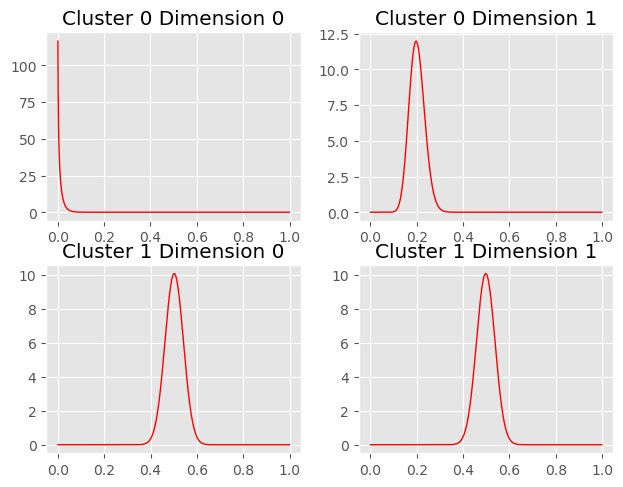

In [10]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [11]:
mb.params

{'weights_param': tensor([0.6666, 0.3334], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[2.8311, 0.9506],
         [0.9928, 0.9885]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.0100, 0.2012],
         [0.5020, 0.4978]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[ 58.9730, 143.6551],
         [160.4023, 159.3371]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[6.3738e-01, 3.6262e-01],
          [8.9749e-04, 9.9910e-01]],
 
         [[7.0843e-04, 9.9929e-01],
          [7.0605e-04, 9.9929e-01]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 4.6837e-05, 1.3869e-04,
          1.2705e-01],
         [3.0094e-08, 3.9169e-07, 1.0209e-07,  ..., 9.9995e-01, 9.9986e-01,
          8.7295e-01]], grad_fn=<CopySlices>),
 'cluster_assignments': tensor([0, 0, 0,  ..., 1, 1, 1])}

### 4 beta-pareto components

In [4]:
N1 = 500
N2 = 300
N3 = 200
N4 = 200
N5 = 200
seed = 123
# Component 1
alpha_pareto = 1
L_pareto = 0.01
H_pareto = 0.2
phi_beta = 0.5
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Component 2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n3=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))

# Component 4
phi_beta_x = 0.3
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n4=150
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV = torch.concat((NV,NV4))
print(NV.shape)
DP = torch.concat((DP,DP4))
print(DP.shape)

alpha_pareto = 1
phi_beta = 0.0001
k_beta = 250
n5=150
NV5, DP5 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5, seed = seed)
NV = torch.concat((NV,NV5))
DP = torch.concat((DP,DP5))


torch.Size([1200, 2])
torch.Size([1200, 2])


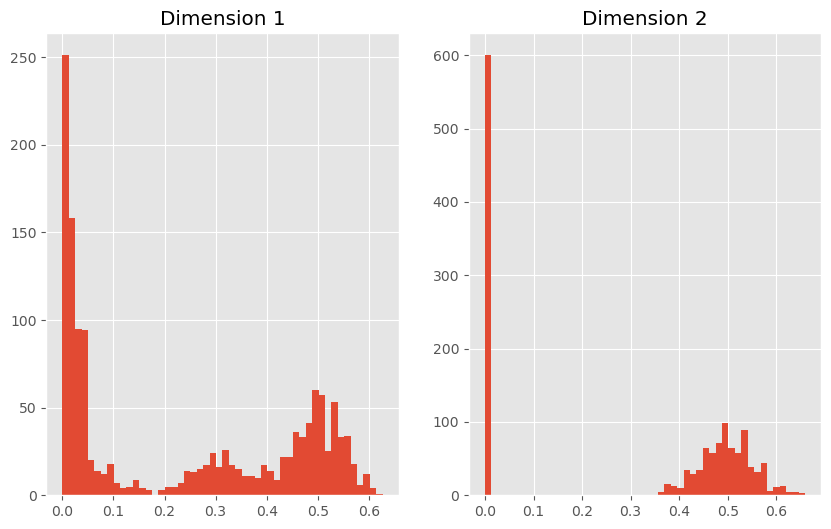

In [5]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [6]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N3)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N3)*4
labels = np.concatenate((labels, labels_5))

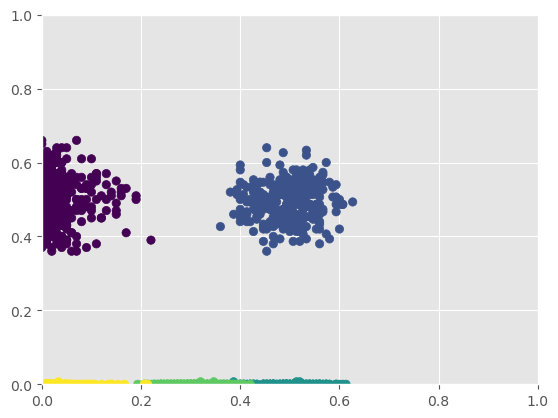

In [7]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K =  4
Beta:  tensor([[ 1.6625,  4.5869],
        [ 1.1834,  1.9527],
        [ 1.9820,  1.6301],
        [ 0.0056, -5.1348]])
Pareto:  tensor([[-2.7849, 14.1625],
        [ 2.3618, -3.2233],
        [-3.2151, -3.1983],
        [ 2.0190, 16.1070]])
Iteration 0: Loss = 15308567.0
weights_param tensor([0.3266, 0.0461, 0.4442, 0.1831], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9987, 1.0086],
        [0.9933, 1.0083],
        [1.0075, 1.0083],
        [1.0083, 1.0077]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.4474, 0.0100],
        [0.0761, 0.4778],
        [0.4789, 0.5417],
        [0.0971, 0.0259]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 98.0272,  98.0193],
        [ 98.0241, 102.0206],
        [101.6954, 101.9465],
        [ 98.0188,  98.0309]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3904, 0.6096],
         [0.5904, 0.4096]],

        [[0.5906, 0.4094],
         [0.3905, 0.6095]],

        [[0.4096, 0.5904],
         [0.3906, 0.6094]],

  

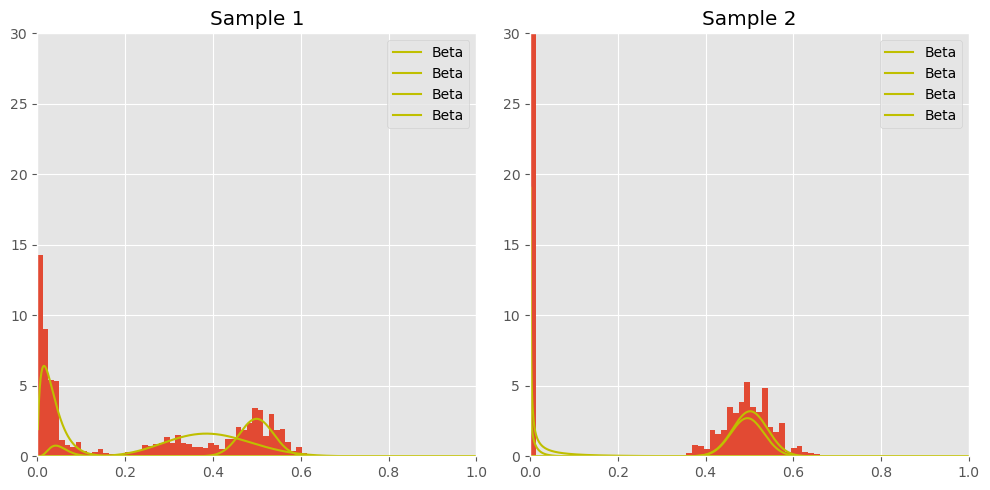

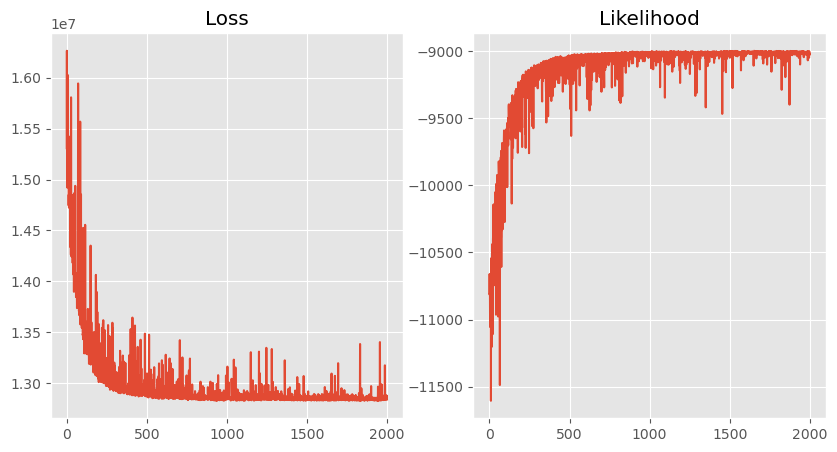

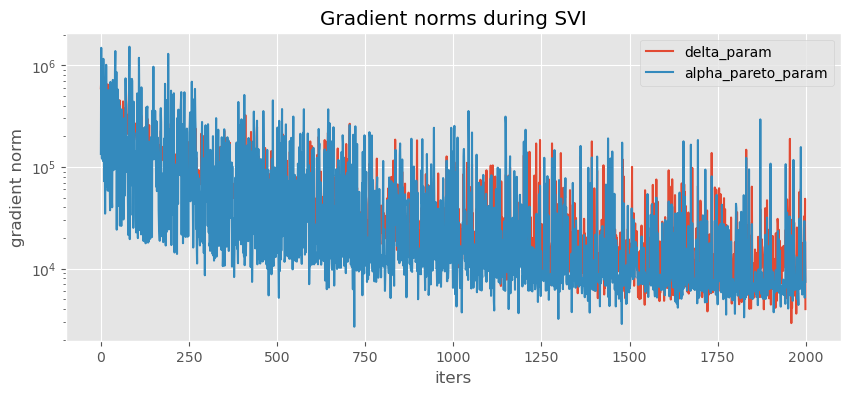

bic:  tensor(69679.2500, grad_fn=<RsubBackward1>)


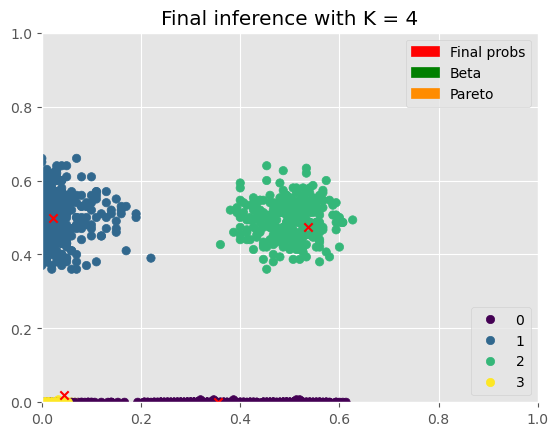

RUN WITH K =  5
Beta:  tensor([[ 1.6364,  2.0128],
        [ 1.6777,  4.5884],
        [ 1.4214,  1.6285],
        [-0.4629, -5.0518],
        [ 2.0109,  4.5859]])
Pareto:  tensor([[-3.2151, -3.1983],
        [-3.2212, 14.5691],
        [ 2.3618, -3.2233],
        [ 2.5513, 16.0029],
        [-2.2190, 13.9305]])
Iteration 0: Loss = 15702769.0
weights_param tensor([0.1215, 0.0027, 0.6848, 0.1218, 0.0692], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0066, 1.0073],
        [0.9989, 1.0072],
        [1.0084, 1.0083],
        [0.9917, 1.0078],
        [1.0067, 1.0077]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.5455, 0.4787],
        [0.5448, 0.0100],
        [0.0100, 0.5480],
        [0.0882, 0.0259],
        [0.3280, 0.0100]], grad_fn=<AddBackward0>)
k_beta_param tensor([[100.7117, 102.0214],
        [101.7294,  98.0929],
        [102.0127,  98.3233],
        [ 98.0615,  98.0941],
        [ 98.1796,  98.0196]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3905, 0.6095

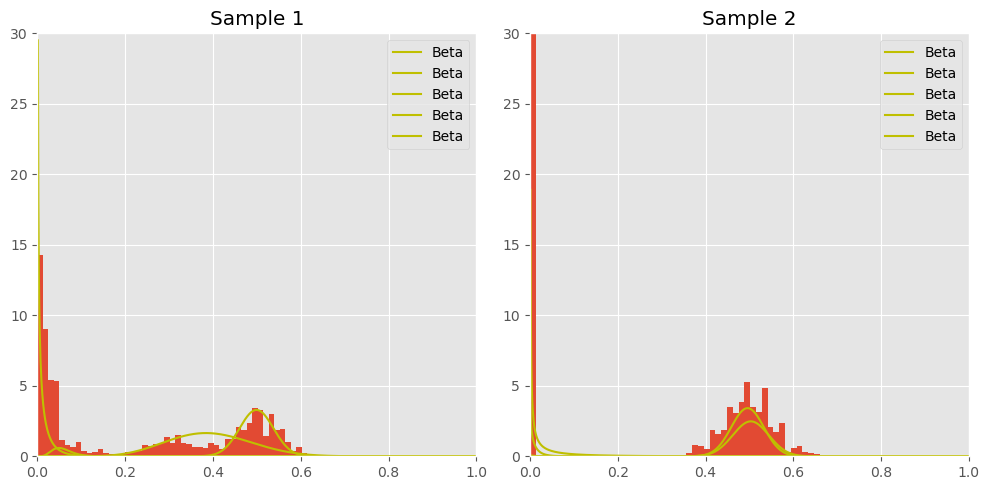

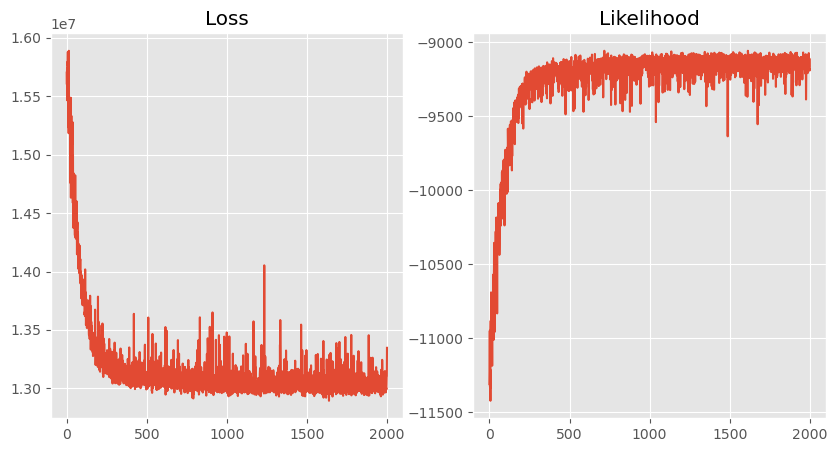

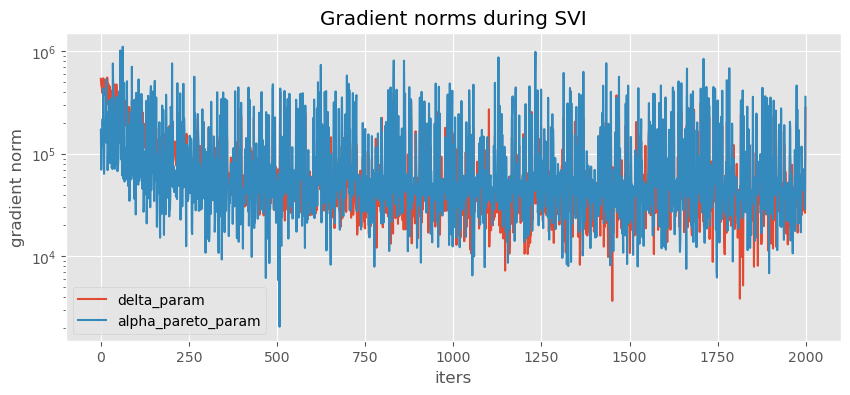

bic:  tensor(80432.6875, grad_fn=<RsubBackward1>)


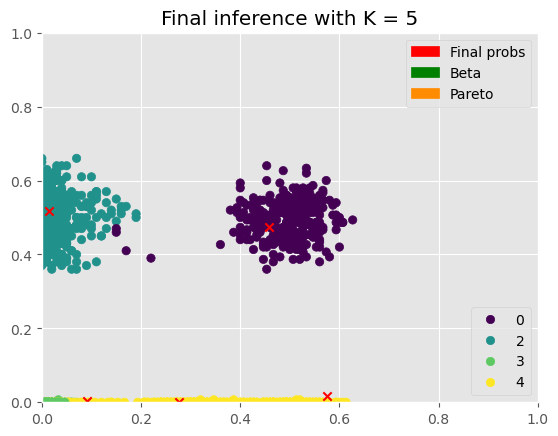

RUN WITH K =  6
Beta:  tensor([[  1.6364,   2.0128],
        [  1.1595,   1.9509],
        [  1.9821, -16.7043],
        [ -0.4629,  -5.0518],
        [  2.4494,   1.6765],
        [  1.5082,   4.5859]])
Pareto:  tensor([[-3.2151, -3.1983],
        [ 2.4139, -3.0060],
        [-3.2212, 14.5691],
        [ 2.5513, 16.0029],
        [ 2.3205, -3.3838],
        [-2.2190, 13.9305]])
Iteration 0: Loss = 16029978.0
weights_param tensor([0.3470, 0.1462, 0.0265, 0.3008, 0.1783, 0.0012],
       grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9969, 0.9988],
        [0.9988, 1.0079],
        [1.0072, 1.0084],
        [0.9916, 1.0084],
        [0.9989, 1.0082],
        [1.0016, 1.0076]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.5455, 0.4787],
        [0.0752, 0.4269],
        [0.4781, 0.0463],
        [0.0885, 0.0259],
        [0.0575, 0.4990],
        [0.3557, 0.0100]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 98.2248, 102.0204],
        [ 98.0362,  98.6025],
        [ 98.301

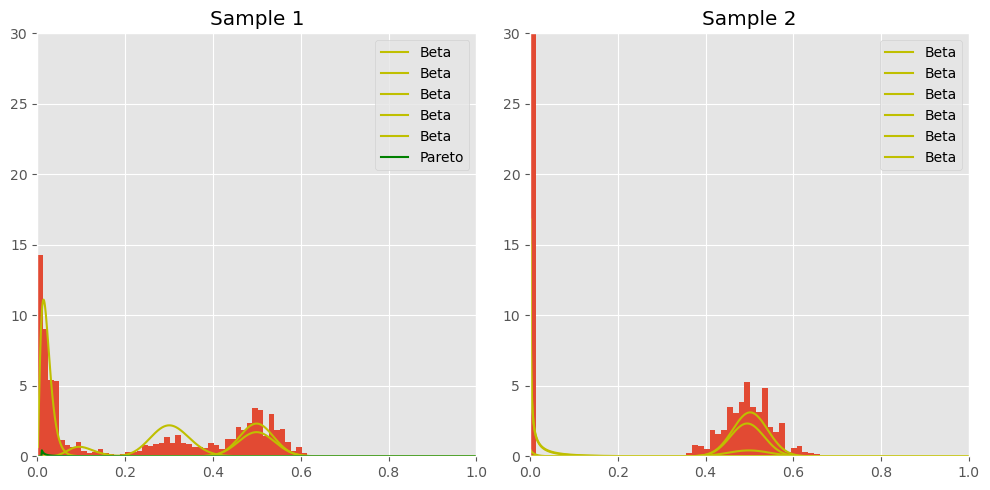

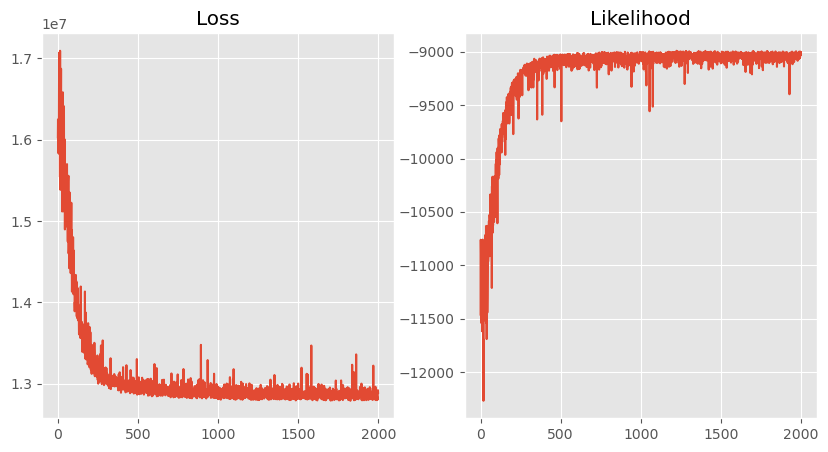

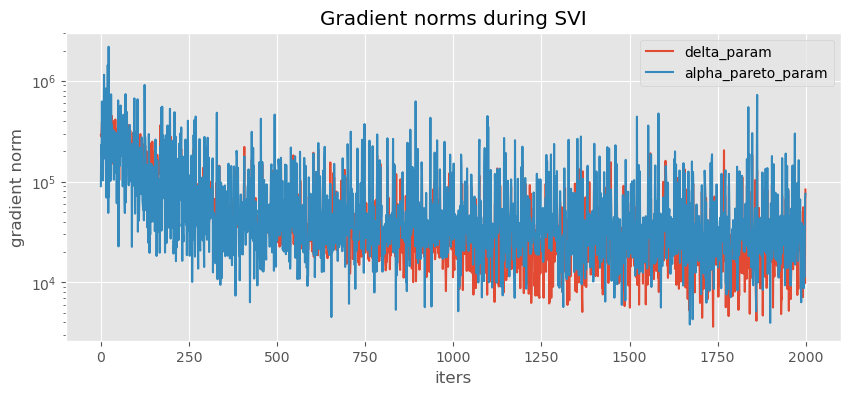

bic:  tensor(90296.4844, grad_fn=<RsubBackward1>)


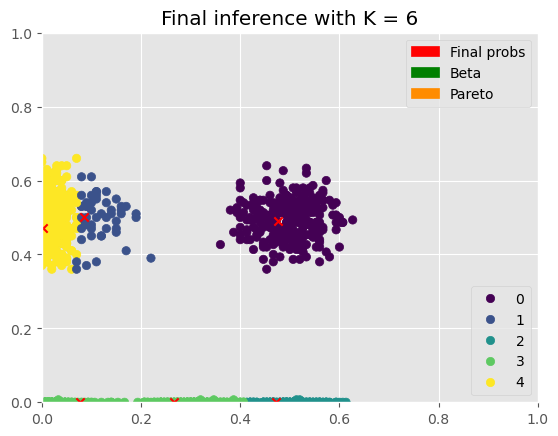

Selected number of clusters is:  4


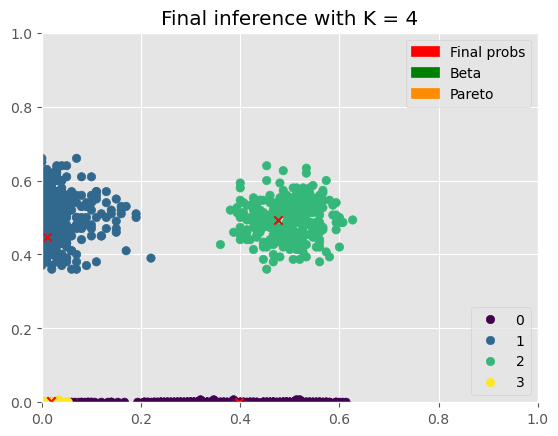

In [8]:
mb = model_mobster_mv.fit(NV, DP, num_iter = 2000, K = [4,5,6], seed = 40, lr = 0.01)

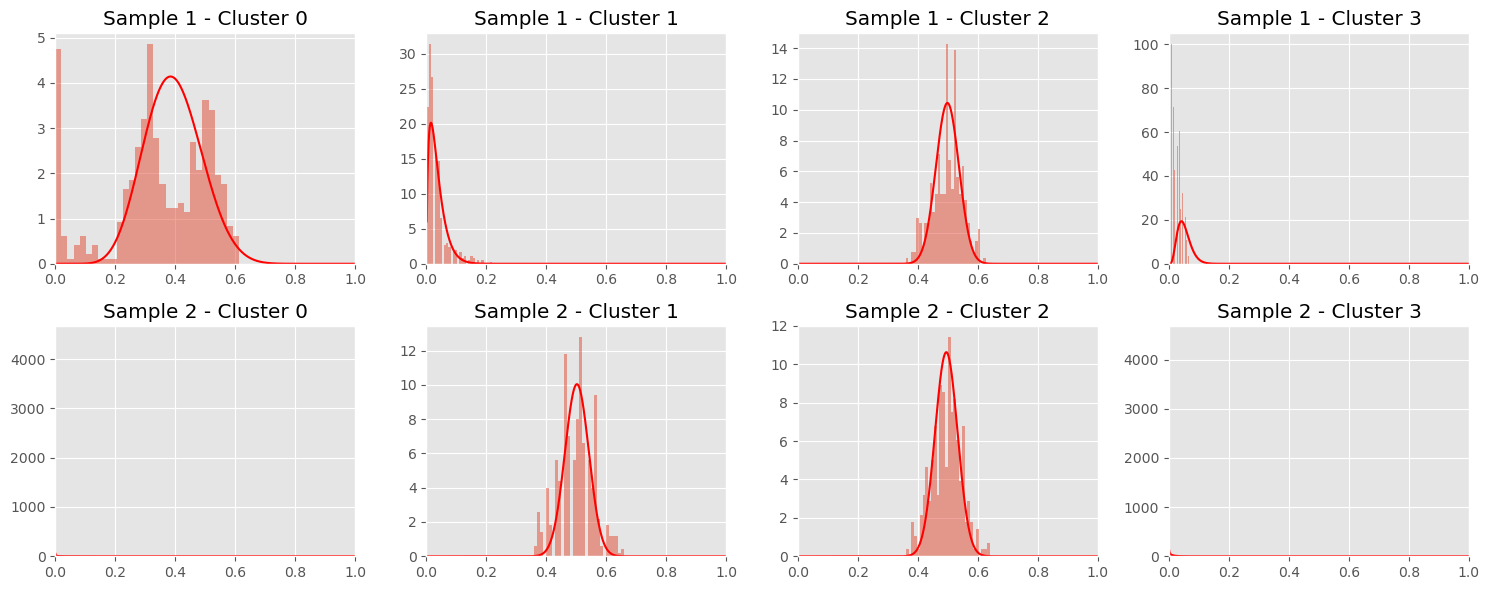

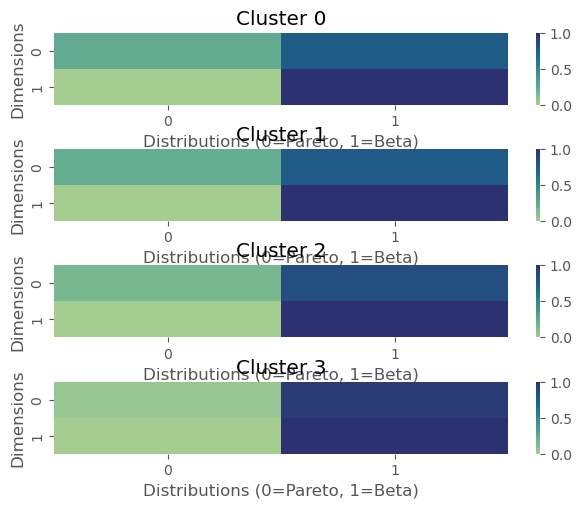

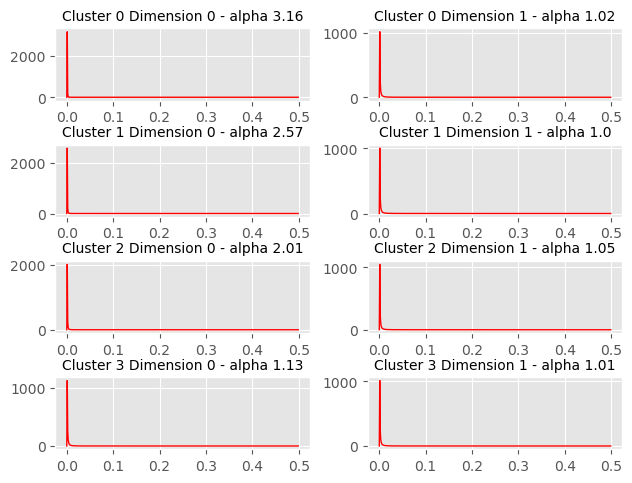

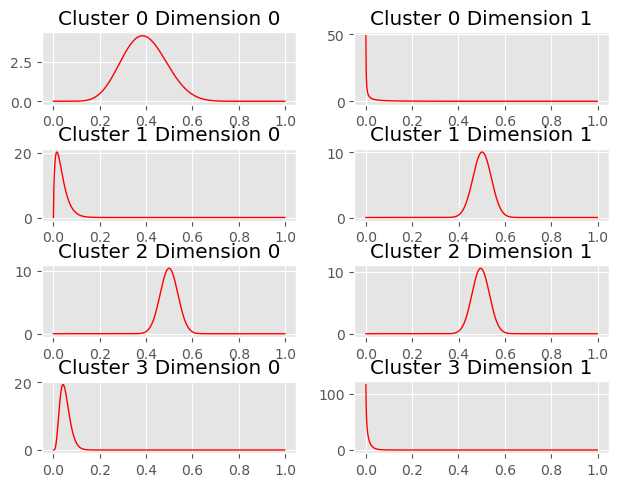

In [24]:
plot_marginals2(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [10]:
mb.params

{'weights_param': tensor([0.3884, 0.3181, 0.2545, 0.0389], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[3.1611, 1.0159],
         [2.5738, 1.0030],
         [2.0088, 1.0472],
         [1.1297, 1.0134]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.3933, 0.0100],
         [0.0354, 0.5015],
         [0.4991, 0.4954],
         [0.0509, 0.0102]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[ 26.0000,   6.6937],
         [ 47.3977, 158.7874],
         [171.8105, 177.8925],
         [ 98.3446,  54.2555]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.2488, 0.7512],
          [0.0021, 0.9979]],
 
         [[0.2305, 0.7695],
          [0.0011, 0.9989]],
 
         [[0.1589, 0.8411],
          [0.0025, 0.9975]],
 
         [[0.0526, 0.9474],
          [0.0039, 0.9961]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[5.5376e-05, 1.2161e-04, 3.8869e-05,  ..., 7.2770e-01, 2.9028e-01,
          1.0525e-02],
         [9.6534e-01, 9.6025e-01, 9.7891e-01,  ..., 1.7

<Axes: >

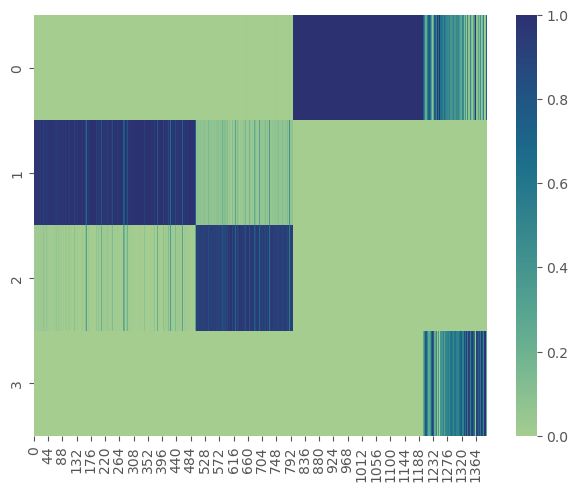

In [11]:
# plot_responsib(mb)
resp = mb.params["responsib"].detach().numpy()
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.tight_layout()
sns.heatmap(resp, ax=ax, vmin=0, vmax=1, cmap="crest")

### rRACES data

In [20]:
NV_r = pd.read_csv("./rRACES_data/NV2.csv")
DP_r = pd.read_csv("./rRACES_data/DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([593, 2])
torch.Size([593, 2])


In [21]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0097)
tensor(0.0092)


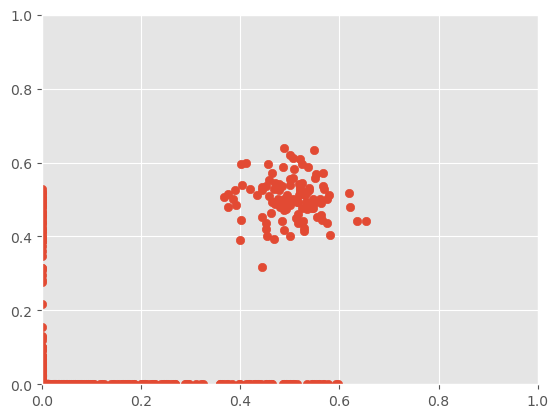

In [22]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

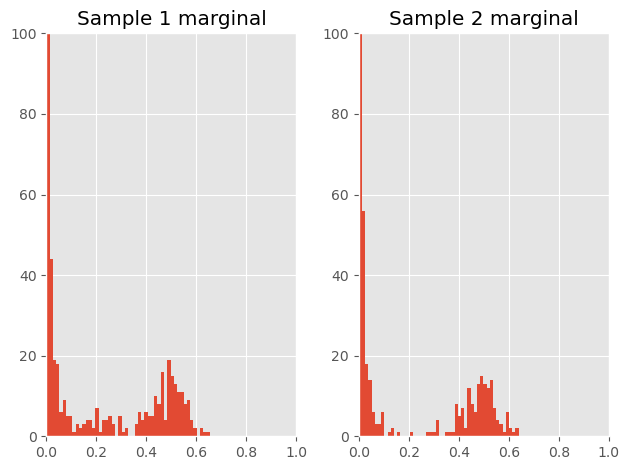

In [23]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[2.1703e-01, 1.0000e-03],
        [4.9993e-01, 5.0346e-01],
        [2.9802e-08, 4.2671e-01],
        [4.6957e-01, 1.0000e-03],
        [1.4685e-02, 1.4474e-02]])


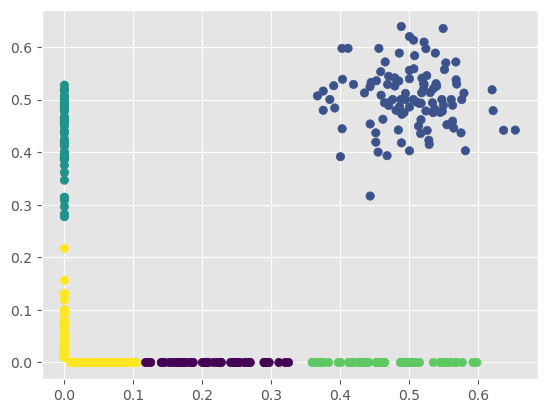

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

RUN WITH K =  5
Beta:  tensor([[1.6362, 2.0134],
        [1.7788, 3.6102],
        [4.5951, 1.6481],
        [1.3745, 3.2186],
        [2.3017, 3.1663]])
Pareto:  tensor([[-3.2186, -3.2327],
        [-1.5497,  4.6052],
        [30.0522, -2.9018],
        [-3.0933,  4.6052],
        [ 3.8367,  3.8657]])
Iteration 0: Loss = 2192897.75
weights_param tensor([0.1210, 0.0027, 0.6826, 0.1262, 0.0674], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0078, 1.0074],
        [1.0075, 1.0052],
        [1.0036, 1.0077],
        [1.0085, 1.0077],
        [0.9976, 1.0086]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.5464, 0.4872],
        [0.2586, 0.0100],
        [0.0100, 0.4723],
        [0.5284, 0.0262],
        [0.0415, 0.0100]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 98.0941, 102.0074],
        [101.9615,  98.0194],
        [ 98.0452,  98.0531],
        [ 98.0380,  98.0471],
        [ 98.0462,  98.0351]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3906, 0.6094],
       

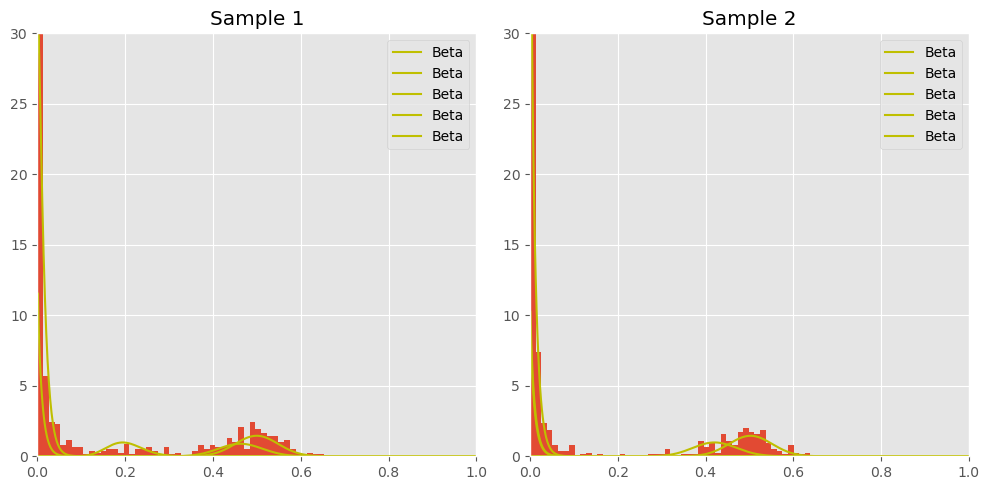

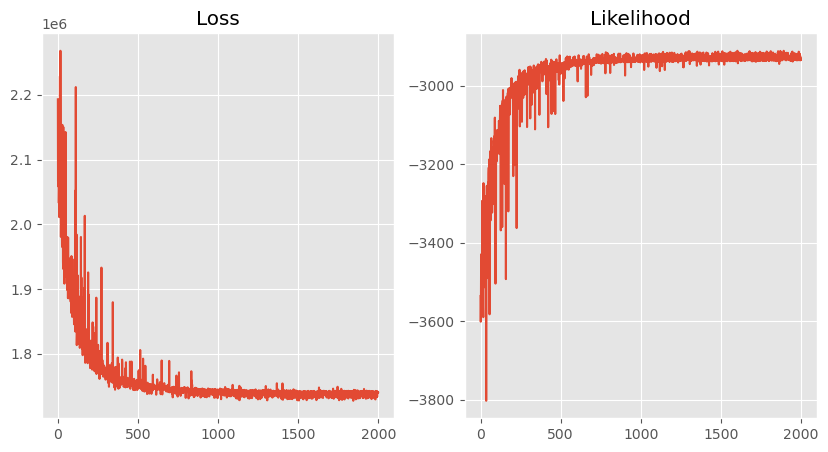

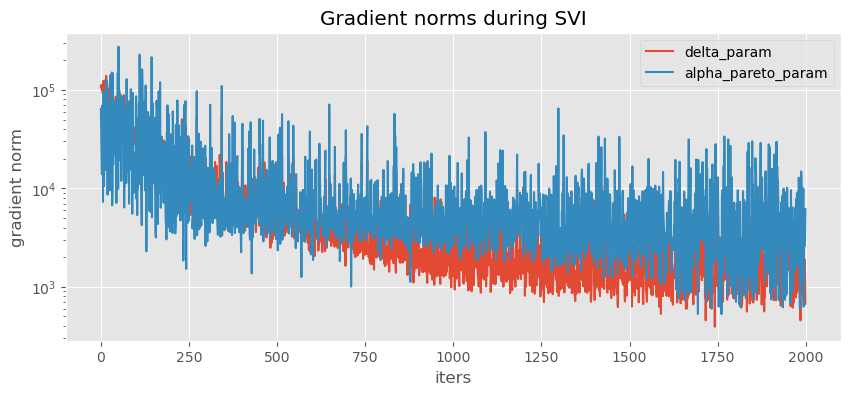

bic:  tensor(28922.8027, grad_fn=<RsubBackward1>)


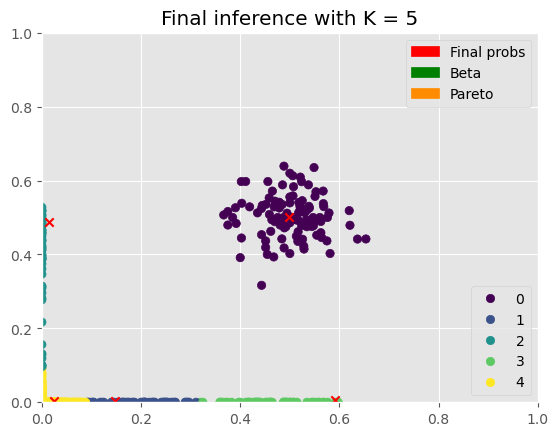

RUN WITH K =  6
Beta:  tensor([[-2.0782e-02,  3.1663e+00],
        [ 1.6721e+00,  1.9506e+00],
        [ 1.9808e+00,  7.9556e-01],
        [-6.2860e+01,  1.9523e+00],
        [ 2.0986e+00,  3.6102e+00],
        [ 1.4718e+00,  2.0455e+00]])
Pareto:  tensor([[ 3.8367,  3.8657],
        [-3.3209, -3.0723],
        [-3.0933,  4.6052],
        [30.0522, -2.9018],
        [-1.5497,  4.6052],
        [-3.1087, -3.3839]])
Iteration 0: Loss = 2016696.875
weights_param tensor([0.3394, 0.1510, 0.0263, 0.2986, 0.1834, 0.0012],
       grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0082, 1.0077],
        [1.0076, 1.0086],
        [1.0080, 1.0079],
        [1.0086, 1.0076],
        [1.0075, 1.0083],
        [1.0020, 1.0078]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0603, 0.0100],
        [0.5500, 0.4419],
        [0.4498, 0.0463],
        [0.0583, 0.4514],
        [0.2465, 0.0100],
        [0.5277, 0.5303]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 98.0677,  98.0212],
        [

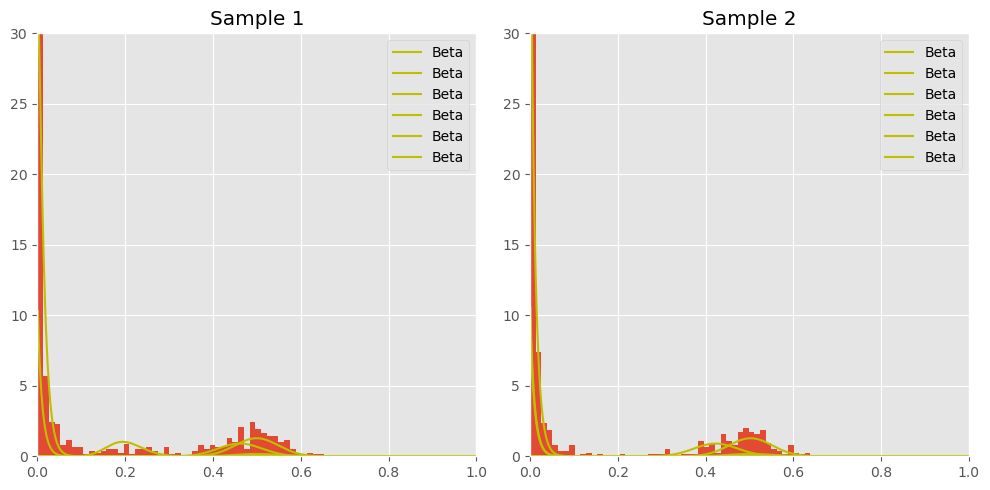

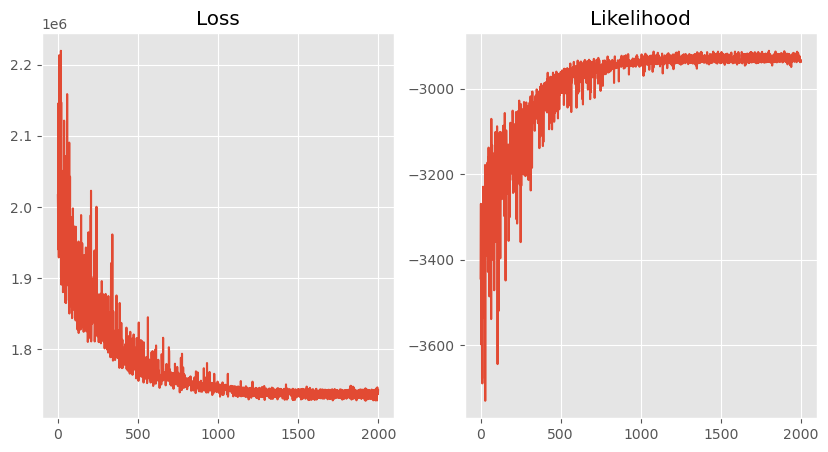

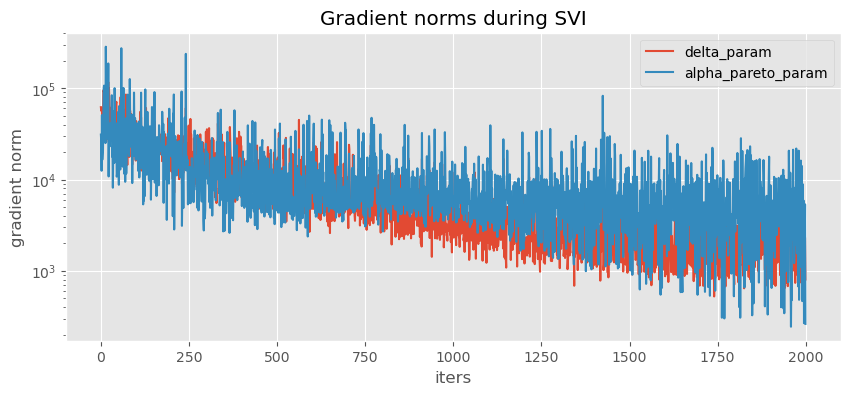

bic:  tensor(32780.0898, grad_fn=<RsubBackward1>)


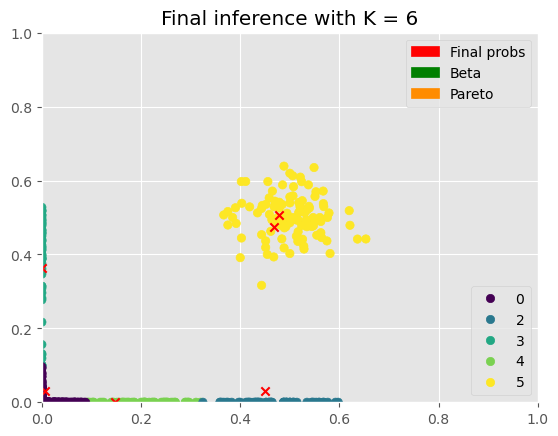

RUN WITH K =  7
Beta:  tensor([[-0.0157,  3.2267],
        [ 1.6721,  1.9506],
        [ 2.0893,  0.7956],
        [-1.1918,  1.9904],
        [ 1.9318,  3.6102],
        [ 1.4718,  2.0455],
        [ 1.4077,  2.0756]])
Pareto:  tensor([[ 3.8307,  3.9515],
        [-3.3209, -3.0723],
        [-1.5497,  4.6052],
        [ 4.6052, -2.4821],
        [-3.0933,  4.6052],
        [-3.1087, -3.3839],
        [ 4.6052, -3.0935]])
Iteration 0: Loss = 2023484.5
weights_param tensor([0.0018, 0.4656, 0.0861, 0.0458, 0.1010, 0.0942, 0.2055],
       grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0072, 1.0074],
        [1.0086, 1.0084],
        [1.0082, 1.0086],
        [1.0080, 1.0082],
        [1.0074, 1.0085],
        [1.0043, 1.0085],
        [1.0079, 1.0086]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0621, 0.0100],
        [0.5500, 0.4419],
        [0.1981, 0.0462],
        [0.0600, 0.3697],
        [0.4956, 0.0100],
        [0.5277, 0.5303],
        [0.0420, 0.4703]], grad_fn=<A

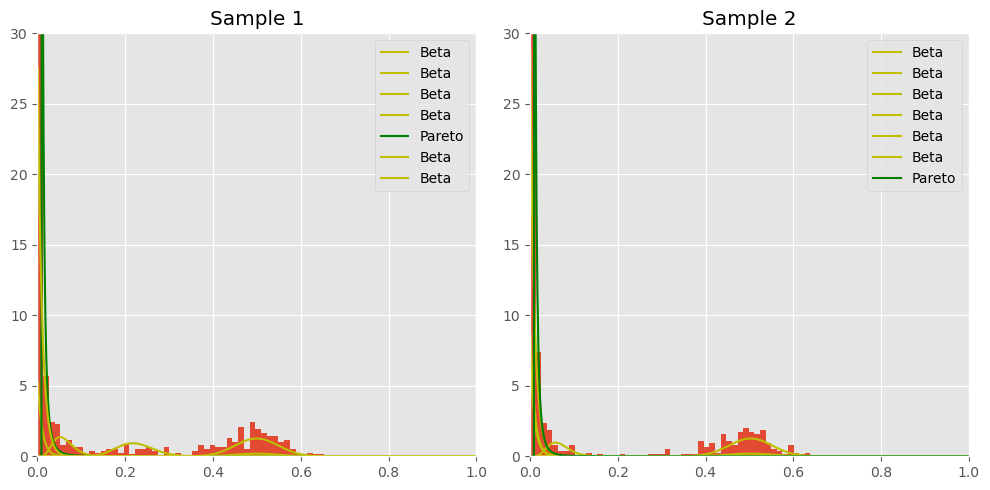

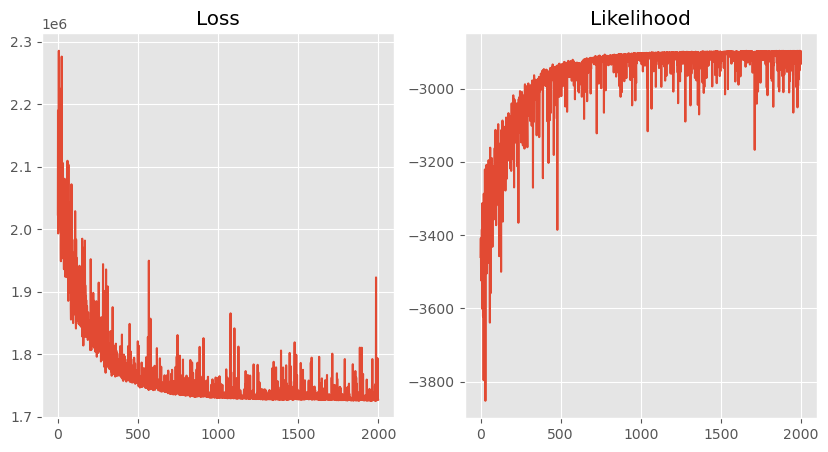

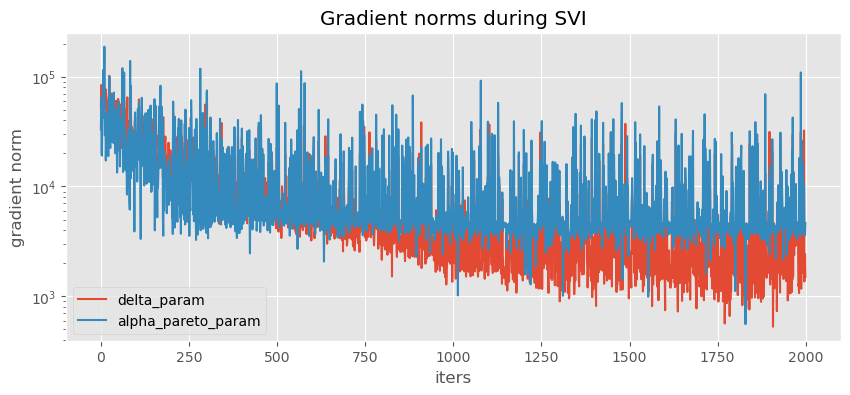

bic:  tensor(37486.2344, grad_fn=<RsubBackward1>)


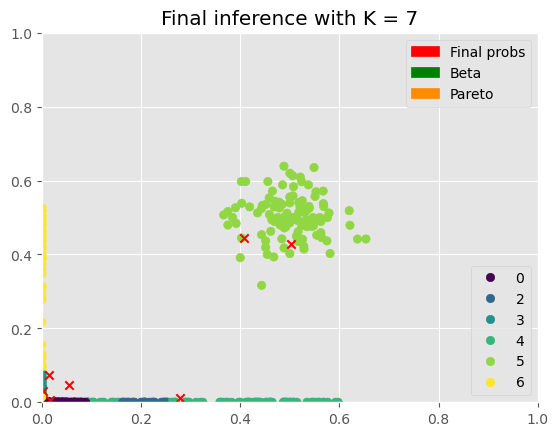

Selected number of clusters is:  5


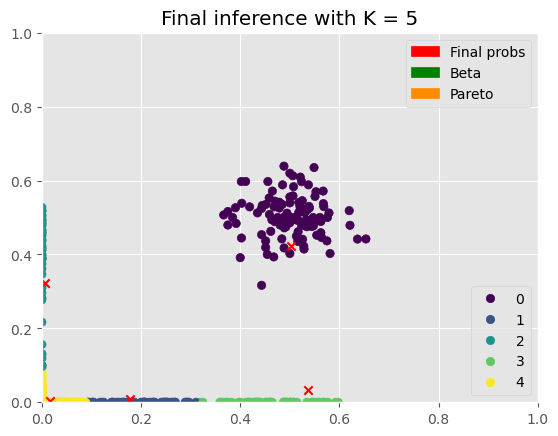

In [25]:
mb = model_mobster_mv.fit(NV, DP, num_iter = 2000, K = [5,6,7], seed = 40, lr = 0.01)

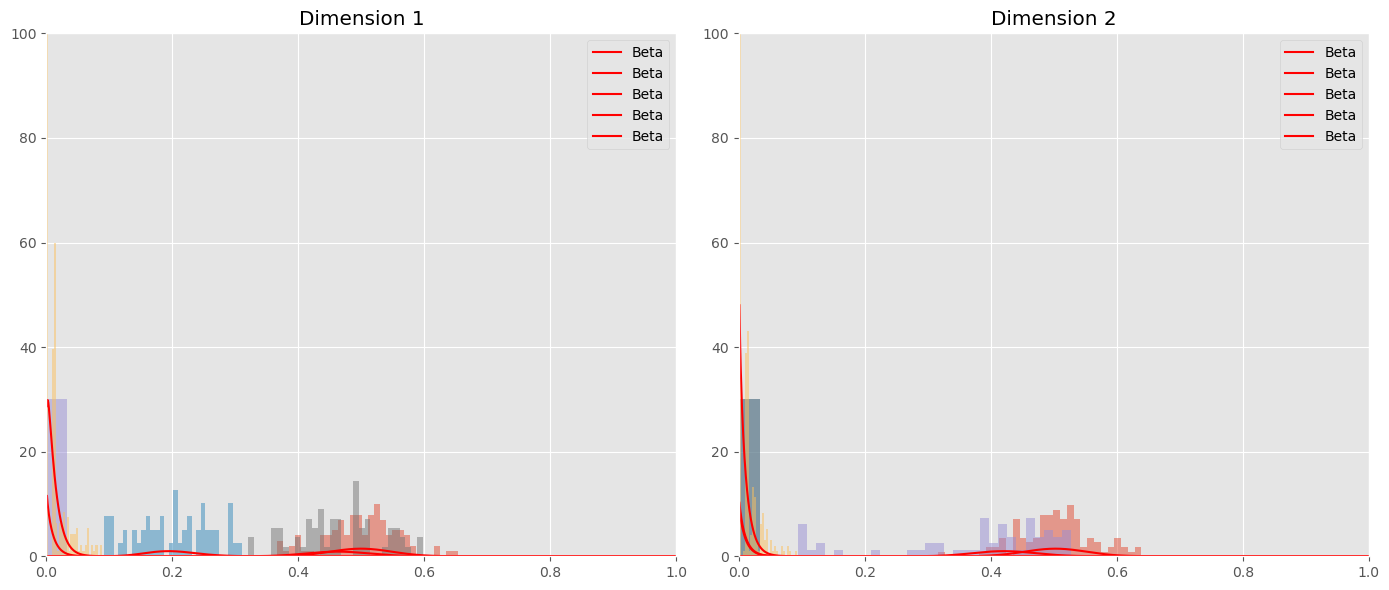

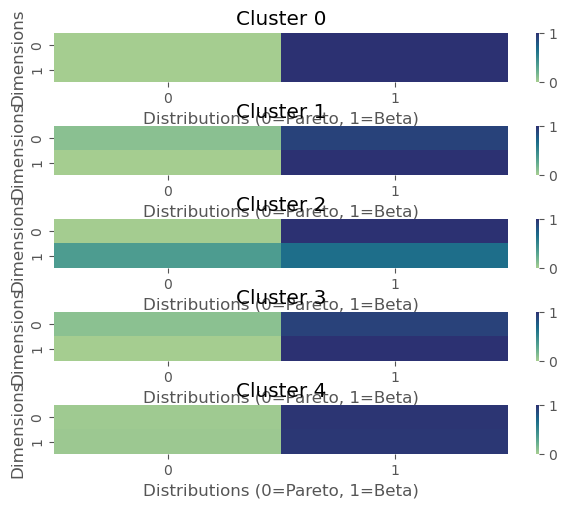

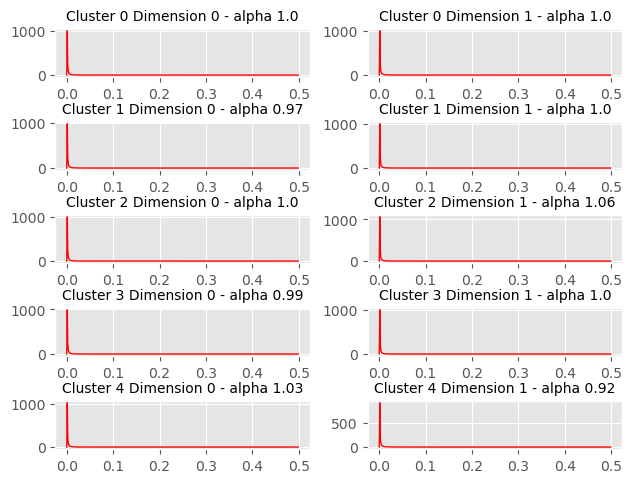

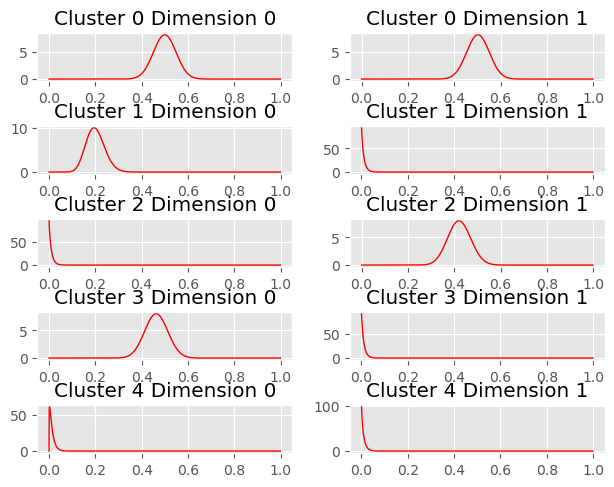

In [26]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [27]:
mb.params

{'weights_param': tensor([0.1773, 0.0980, 0.1223, 0.1107, 0.4917], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.0021, 1.0011],
         [0.9748, 0.9992],
         [1.0048, 1.0635],
         [0.9930, 1.0024],
         [1.0282, 0.9187]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.4994, 0.5025],
         [0.2002, 0.0100],
         [0.0100, 0.4219],
         [0.4630, 0.0101],
         [0.0127, 0.0100]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[106.3239, 106.0669],
         [ 99.2420,  94.4835],
         [ 93.8646,  99.1512],
         [101.0525,  93.8782],
         [ 93.8118,  89.3948]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.0020, 0.9980],
          [0.0017, 0.9983]],
 
         [[0.0952, 0.9048],
          [0.0020, 0.9980]],
 
         [[0.0059, 0.9941],
          [0.3509, 0.6491]],
 
         [[0.0926, 0.9074],
          [0.0037, 0.9963]],
 
         [[0.0223, 0.9777],
          [0.0342, 0.9658]]], grad_fn=<DivBackward0>),
 'responsib': t

### rRACES longitudinal data

In [28]:
NV_r = pd.read_csv("./rRACES_data/NV_long.csv")
DP_r = pd.read_csv("./rRACES_data/DP_long.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([1224, 2])
torch.Size([1224, 2])


In [29]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0094)
tensor(0.0095)


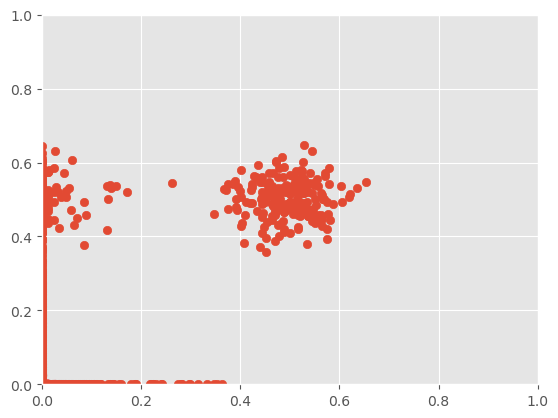

In [30]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

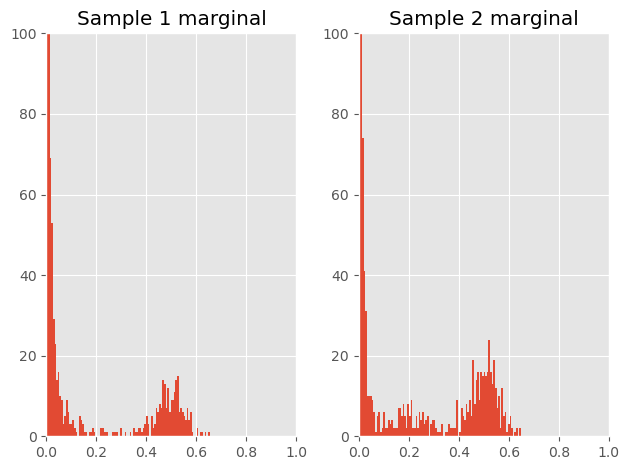

In [31]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 100)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 100)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[1.4442e-02, 1.1785e-02],
        [4.9358e-01, 5.0280e-01],
        [1.6109e-02, 4.9525e-01],
        [2.2913e-01, 1.4901e-08],
        [2.2352e-08, 2.1557e-01]])


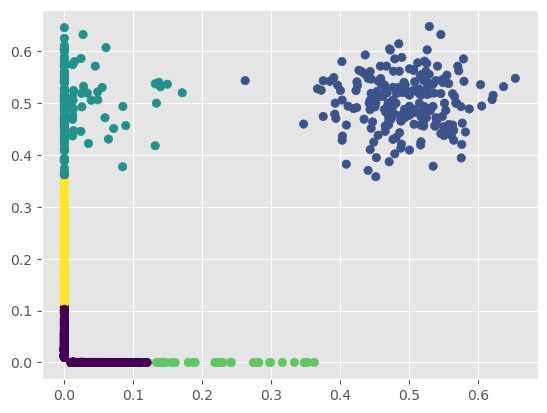

In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

RUN WITH K =  5
Beta:  tensor([[-4.9133e-02,  3.4333e+00],
        [ 1.6793e+00,  1.9529e+00],
        [ 3.0036e+00,  1.6300e+00],
        [-6.4276e+01,  2.1120e+00],
        [ 2.0837e+00,  4.5951e+00]])
Pareto:  tensor([[ 3.8701,  4.2767],
        [-3.1930, -3.2300],
        [ 3.6516, -3.1998],
        [30.6276, -1.5362],
        [-1.6583, 31.4385]])
Iteration 0: Loss = 9603962.0
weights_param tensor([0.1188, 0.0027, 0.6851, 0.1267, 0.0666], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0075, 1.0075],
        [1.0077, 1.0014],
        [1.0077, 1.0076],
        [1.0082, 1.0076],
        [1.0082, 1.0085]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0601, 0.0100],
        [0.5376, 0.4795],
        [0.0100, 0.5420],
        [0.0583, 0.2392],
        [0.2535, 0.0100]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 98.0249,  98.0215],
        [102.0146, 102.0192],
        [ 98.0436,  98.0195],
        [ 98.0201,  98.2207],
        [ 98.4563,  98.0260]], grad_fn=<AddBackward0

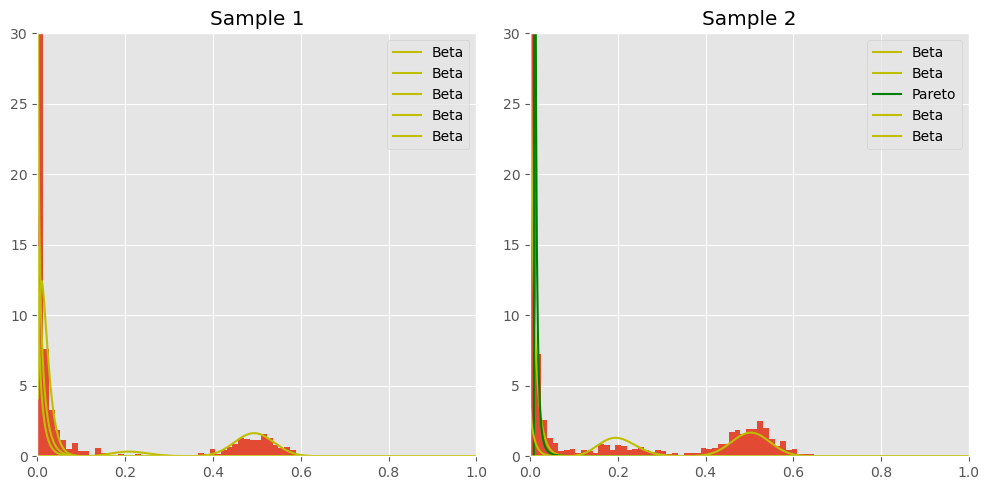

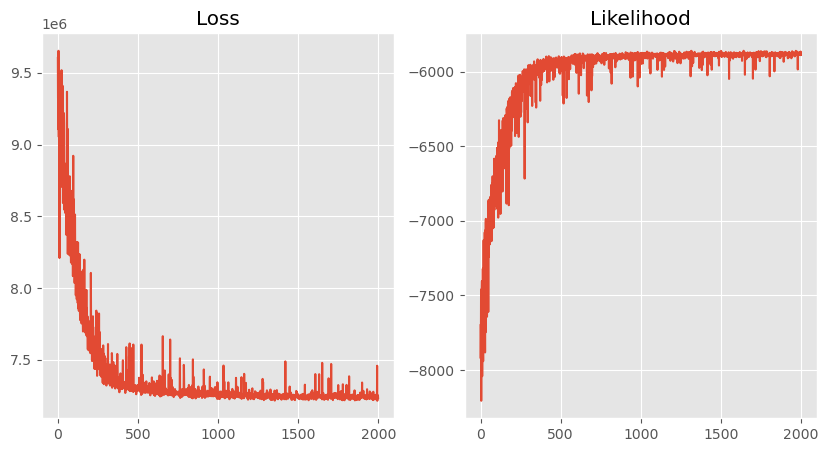

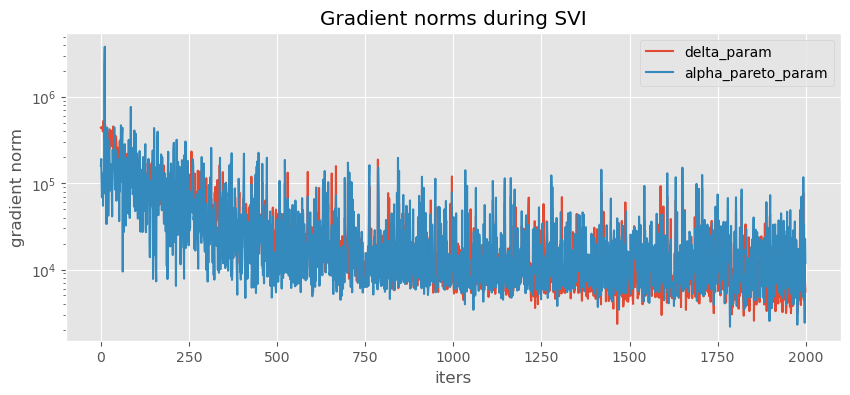

bic:  tensor(64791.0078, grad_fn=<RsubBackward1>)


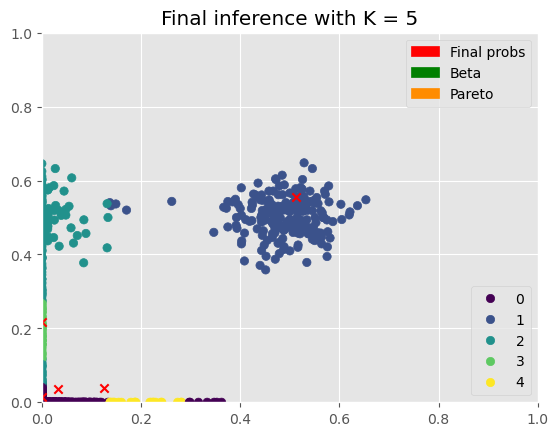

RUN WITH K =  6
Beta:  tensor([[-6.2410,  2.0711],
        [ 1.6793,  1.9529],
        [ 3.1469, -0.7180],
        [-1.5315,  1.9351],
        [ 3.1510,  1.4473],
        [ 1.5062,  4.5951]])
Pareto:  tensor([[ 8.6895, -2.1875],
        [-3.1930, -3.2300],
        [ 3.8388,  4.5254],
        [ 3.5242, -3.2502],
        [ 4.6052, -1.0303],
        [-1.6583, 31.4385]])
Iteration 0: Loss = 8394992.0
weights_param tensor([0.3395, 0.1509, 0.0263, 0.2992, 0.1828, 0.0012],
       grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0083, 1.0079],
        [1.0077, 1.0079],
        [1.0080, 1.0077],
        [1.0086, 1.0076],
        [1.0075, 1.0079],
        [0.9919, 1.0084]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0472, 0.2787],
        [0.5376, 0.4795],
        [0.0100, 0.0565],
        [0.0775, 0.5338],
        [0.0267, 0.1222],
        [0.2820, 0.0100]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 98.0800,  98.0205],
        [102.0211, 102.0181],
        [101.0978,  98.2615],

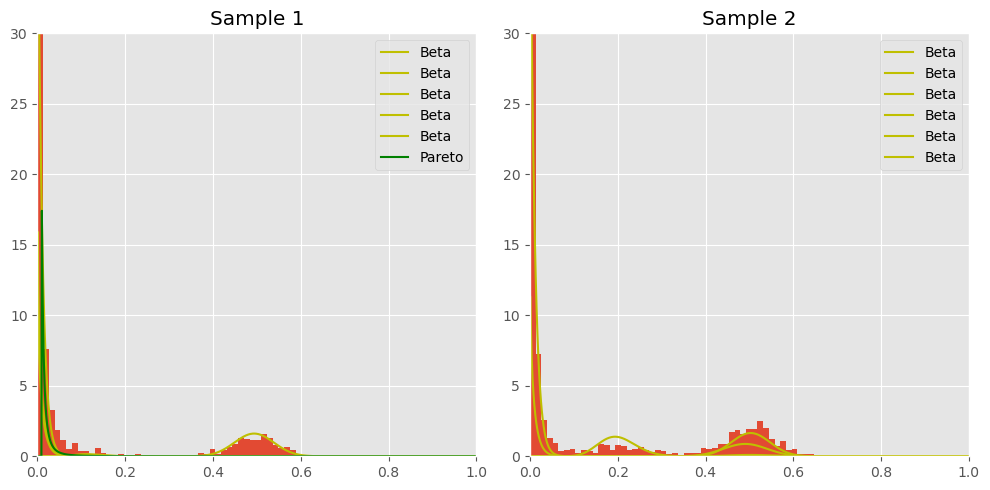

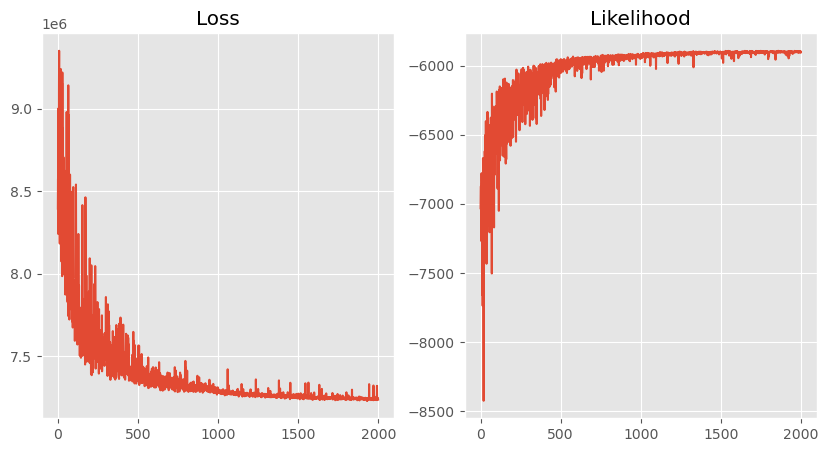

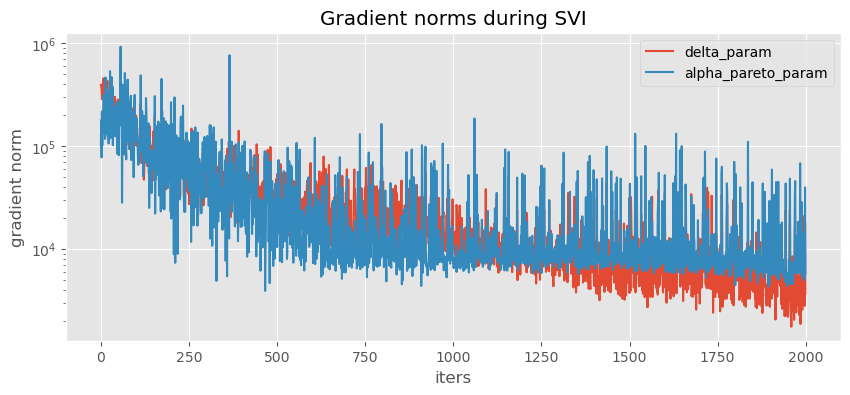

bic:  tensor(73306.8750, grad_fn=<RsubBackward1>)


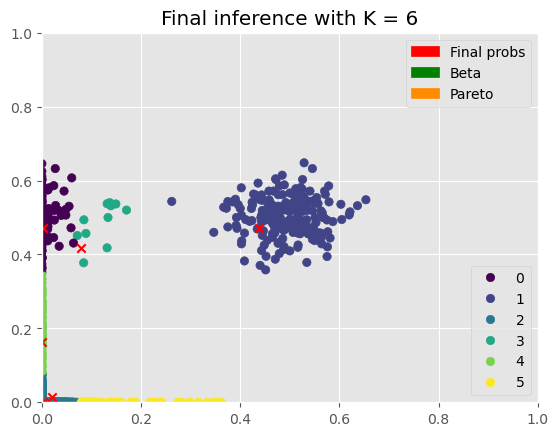

RUN WITH K =  7
Beta:  tensor([[ 1.6505,  2.0126],
        [ 1.1790,  2.0730],
        [ 2.8980,  1.6269],
        [-1.9354,  2.2486],
        [ 0.1433,  1.6139],
        [ 1.4533,  2.0407],
        [ 1.8099, 13.7978]])
Pareto:  tensor([[-2.9837, -3.1818],
        [ 4.6052, -1.0303],
        [ 3.5242, -3.2502],
        [ 3.8388,  4.5254],
        [ 8.6895, -2.1875],
        [-3.3413, -3.2666],
        [-1.6583, 31.4385]])
Iteration 0: Loss = 8478183.0
weights_param tensor([0.0018, 0.4651, 0.0861, 0.0458, 0.0984, 0.0974, 0.2053],
       grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0084, 0.9929],
        [1.0086, 1.0082],
        [1.0084, 1.0086],
        [1.0080, 1.0083],
        [1.0076, 1.0084],
        [0.9917, 1.0084],
        [1.0076, 1.0086]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.4900, 0.4747],
        [0.0436, 0.1448],
        [0.0100, 0.5500],
        [0.0728, 0.0361],
        [0.0280, 0.2563],
        [0.5500, 0.4999],
        [0.2691, 0.0100]], grad_fn=<A

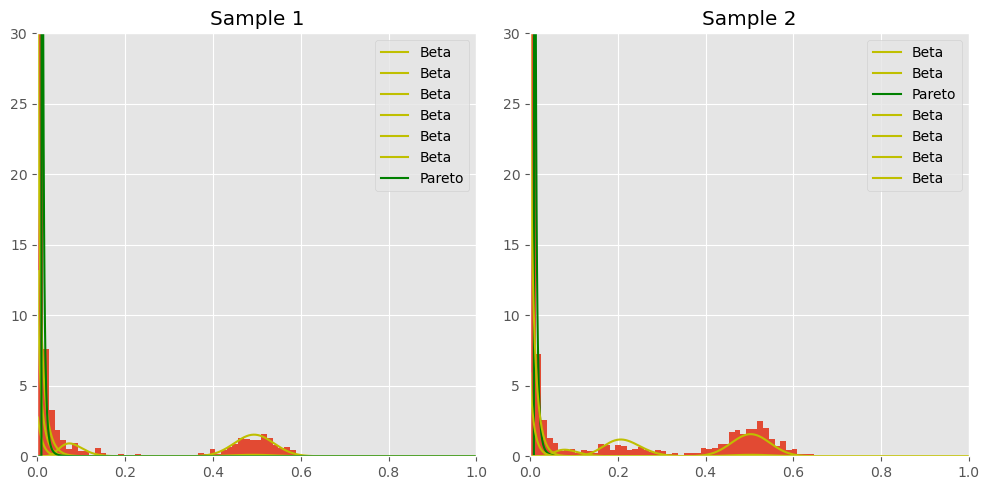

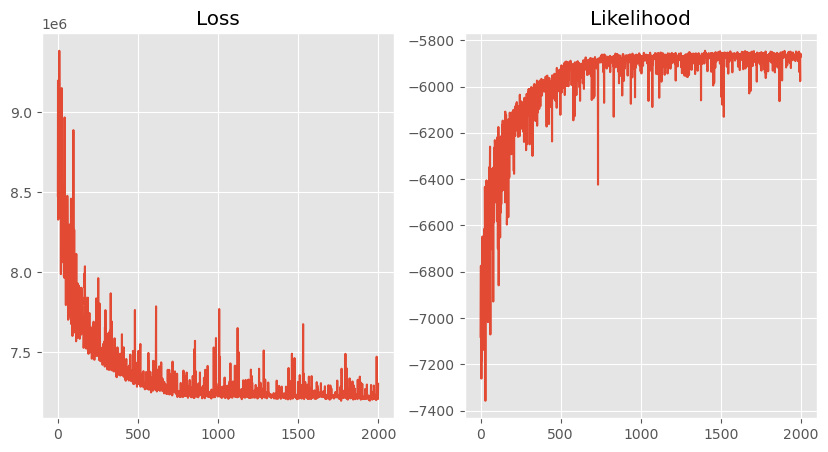

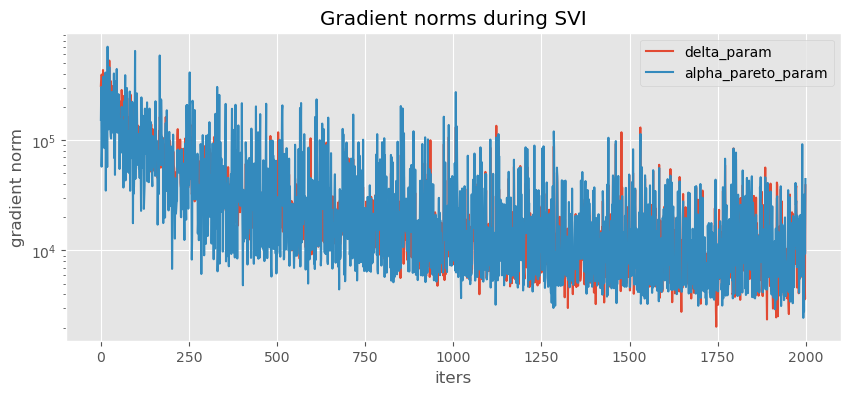

bic:  tensor(84478.2734, grad_fn=<RsubBackward1>)


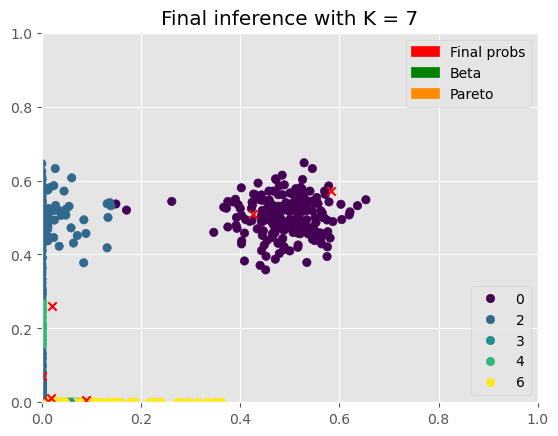

Selected number of clusters is:  5


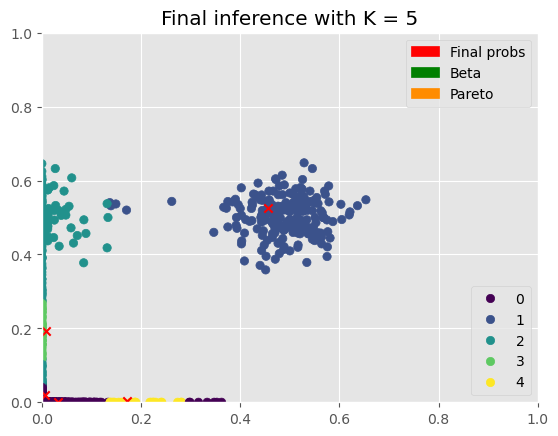

In [33]:
mb = model_mobster_mv.fit(NV, DP, num_iter = 2000, K = [5,6,7], seed = 40, lr = 0.01)

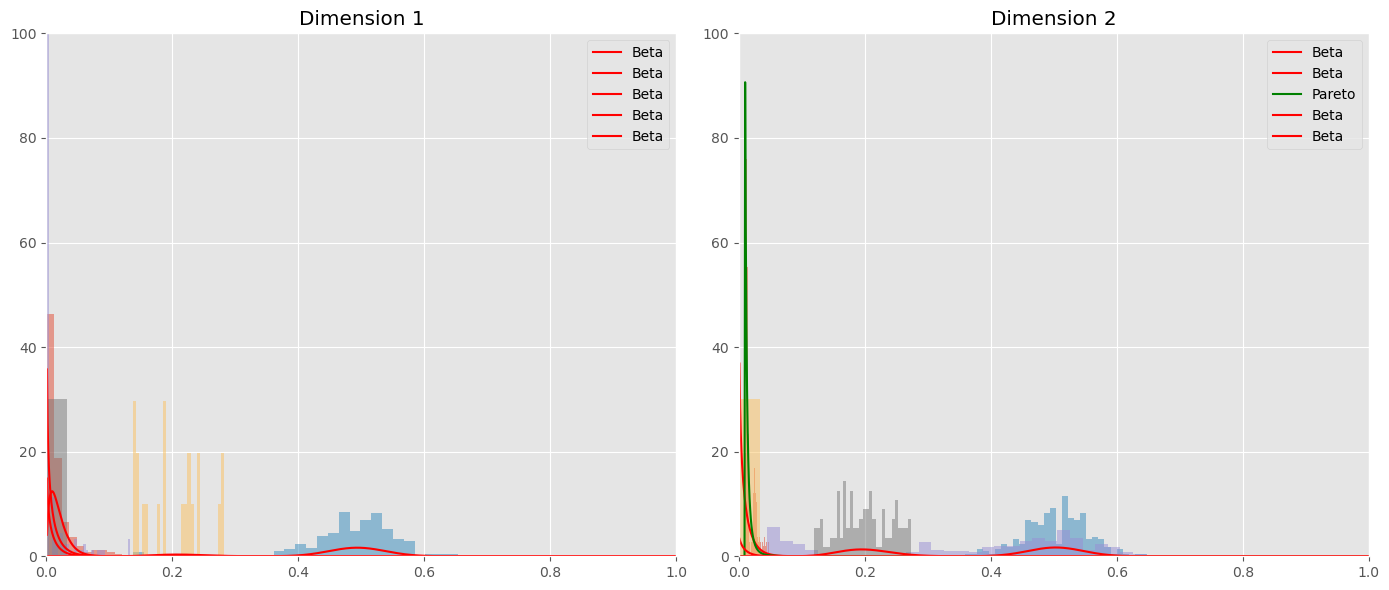

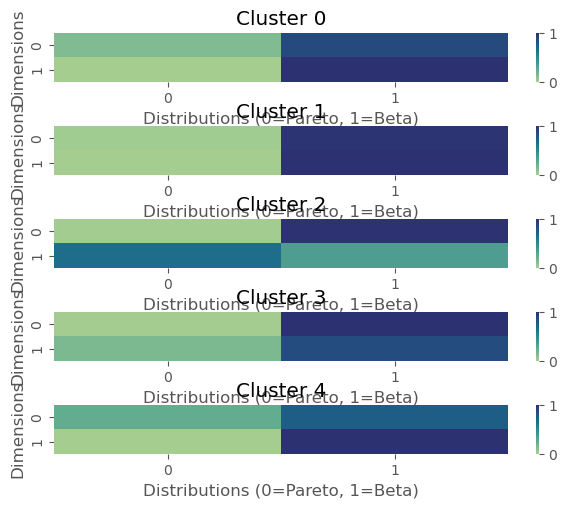

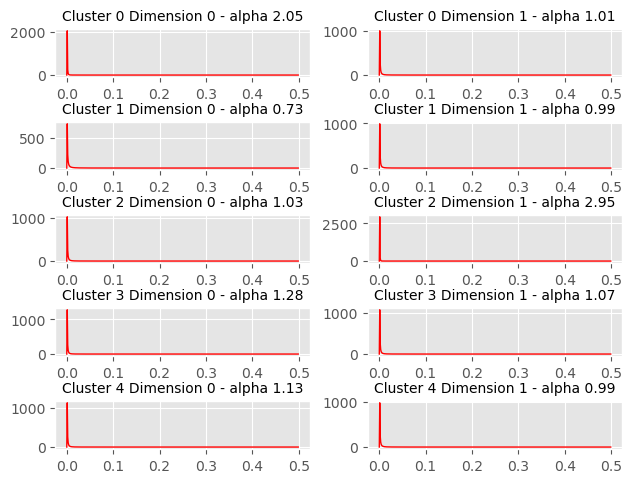

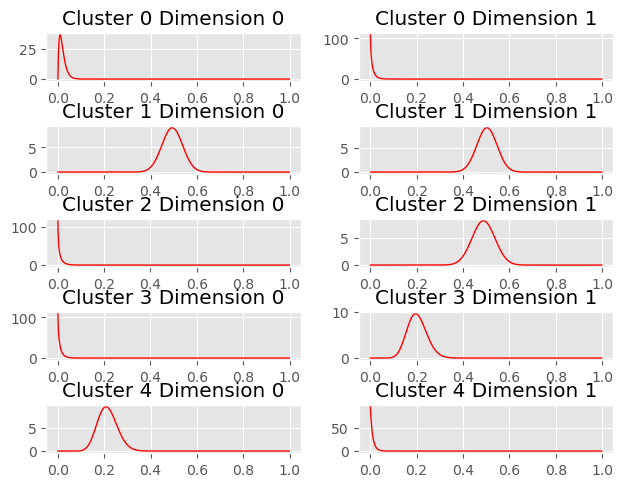

In [34]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [35]:
# a = dist.Normal(200, 15).sample([2000])
# plt.hist(a, bins = 50)

In [36]:
# Without small gaussian noise
mb.params

{'weights_param': tensor([0.3377, 0.1831, 0.3073, 0.1368, 0.0351], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[2.0478, 1.0101],
         [0.7341, 0.9946],
         [1.0278, 2.9494],
         [1.2819, 1.0688],
         [1.1285, 0.9854]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.0196, 0.0100],
         [0.4935, 0.5028],
         [0.0100, 0.4881],
         [0.0102, 0.2015],
         [0.2140, 0.0100]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[ 93.5704,  72.8329],
         [126.5017, 132.8058],
         [ 59.7257, 102.5558],
         [ 70.2616,  91.6067],
         [ 93.1751,  93.0259]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.1323, 0.8677],
          [0.0026, 0.9974]],
 
         [[0.0177, 0.9823],
          [0.0017, 0.9983]],
 
         [[0.0081, 0.9919],
          [0.6568, 0.3432]],
 
         [[0.0054, 0.9946],
          [0.1468, 0.8532]],
 
         [[0.2441, 0.7559],
          [0.0033, 0.9967]]], grad_fn=<DivBackward0>),
 'responsib': t